# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_3.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/sample_submission.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/class_map.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_3.parquet


In [4]:
import torch

debug=False
submission=False
batch_size=128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size=64
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('.')

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 1
CPU times: user 9.99 s, sys: 4.07 s, total: 14.1 s
Wall time: 3.03 s


In [10]:
#  import sys 

# # These are the usual ipython objects, including this one you are creating 
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# # Get a sorted list of the objects and their sizes 
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

<a id="dataset"></a>
# Dataset

In [11]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [12]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [13]:
train_dataset_noaug = BengaliAIDataset(train_images, train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [14]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [15]:
# print(image[:5,:5])
# print(20/255)

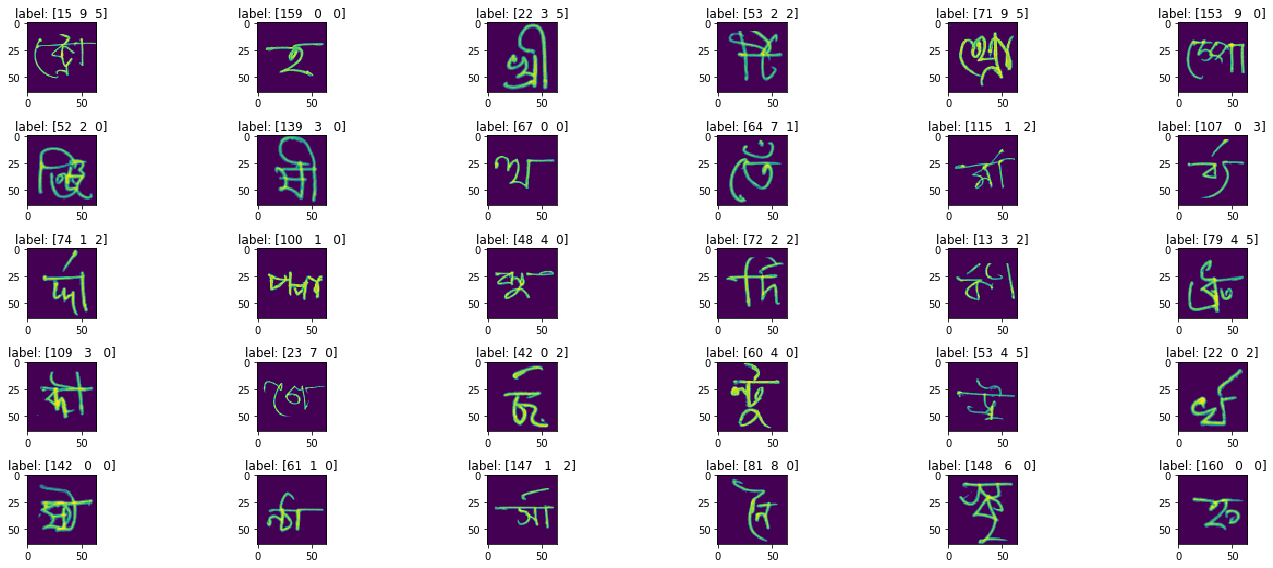

<Figure size 432x288 with 0 Axes>

In [16]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = 80.0/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [17]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 20
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=80./255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

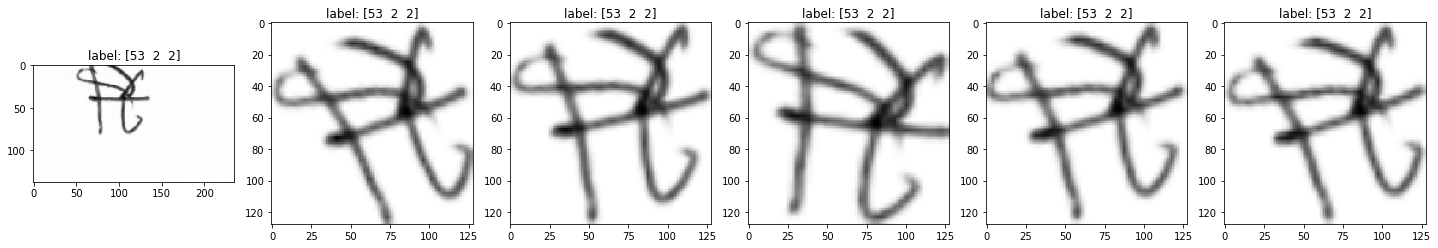

In [18]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[3]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

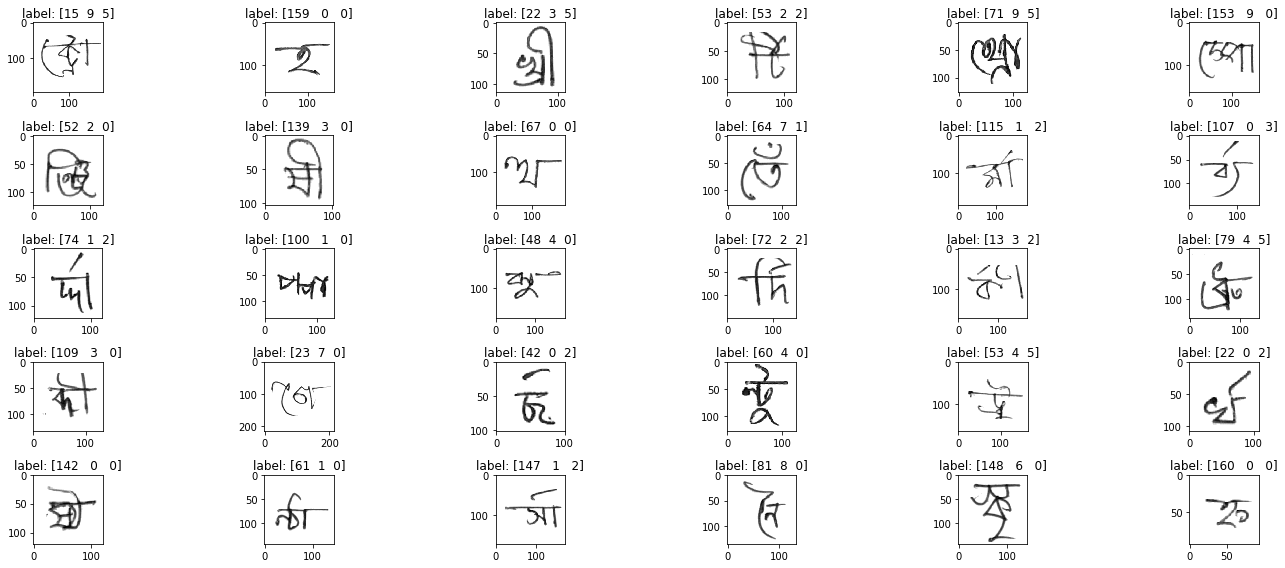

In [19]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=80./255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

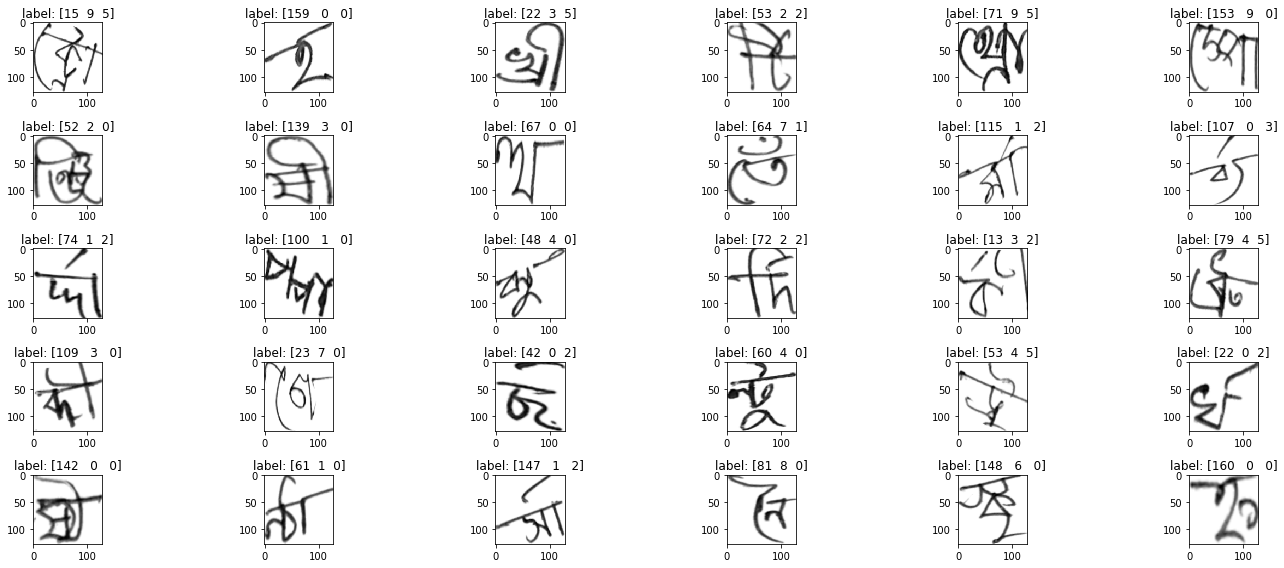

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize(crop_char_image_thin(affine_image((crop_char_image(image, threshold=100./255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [21]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=80.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
        if self.crop:
            x = crop_char_image_thin(x, threshold=self.threshold/2)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
#            x = apply_aug(A.Cutout(num_holes=1,  max_h_size=16, max_w_size=16, p=1.0),x)  # Deprecated...
             x = apply_aug(A.CoarseDropout(max_holes=3, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=20,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [22]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.5,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.2,
    piece_affine_ratio=0.1, ssr_ratio=0.2, elastic_distortion_ratio=0.1) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

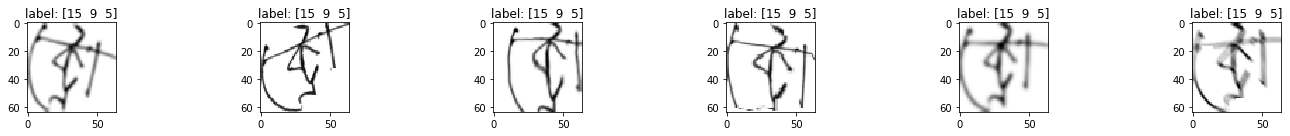

In [23]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

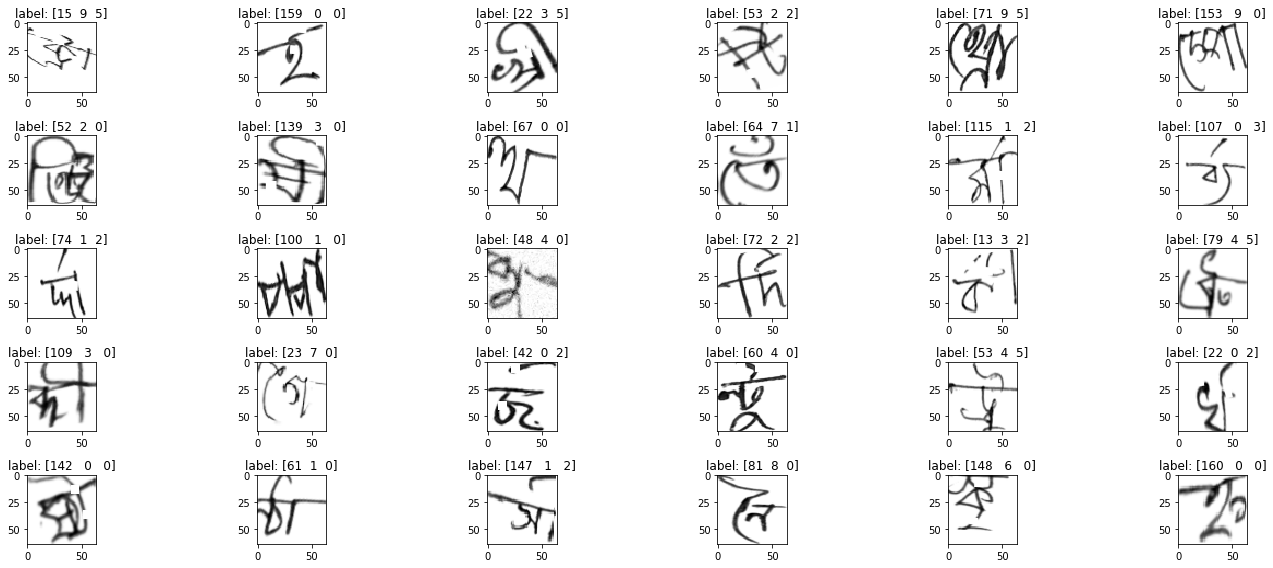

In [24]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [25]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [26]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [27]:
a = np.array([2,3])
b = np.array([4,5,6])

In [28]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [29]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [30]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [31]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [32]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [58]:
import CLR as CLR
import OneCycle as OneCycle

In [79]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [60]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [61]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

# --- Training setting ---
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

# def schedule_lr(metrics):
#     avg_mae = metrics['loss']
#     # --- update lr ---
#     lr = scheduler.optimizer.param_groups[0]['lr']
#     scheduler.step(avg_mae)
#     log_report.report('lr', lr)

n_total 186


## prepare data

In [37]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [38]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        elem['mode'] = mode
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [39]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [40]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [41]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [80]:
def clr_test(data_loader, optimizer, clr):
    t = tqdm(data_loader, leave=False, total=len(data_loader))
    running_loss = 0.
    avg_beta = 0.98
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
        smoothed_loss = running_loss / (1 - avg_beta**(batch_idx+1))
        t.set_postfix(loss=smoothed_loss)
        
        lr = clr.calc_lr(smoothed_loss)
        if lr == -1 :
            break
        update_lr(optimizer, lr)   
        
        loss.backward()
        optimizer.step()
        
    return metrics_total

In [81]:
def train_model(epoch, data_loader, log_report, use_cycle = False):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        if use_cycle:    
            lr, mom = onecycle.calc()
            update_lr(optimizer, lr)
            
#             update_mom(optimizer, mom)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    if not use_cycle:
        schedule_lr(metrics_total)
    else:
        lr = optimizer.param_groups[0]['lr']
        log_report.report('lr', lr)
    return metrics_total

In [44]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [45]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall):
    mode = list("000")
    if(epoch%10==0):
        model_file_name = outdir / 'predictor_{}_{}.pt'.format(l1,epoch)
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = outdir / 'predictor_min_loss.pt'
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = outdir / 'predictor_max_recall.pt'
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [46]:
# mode = list("000")
# mode = ''.join(mode)
# print(mode)
# msg = ''
# key ="mode"
# value = mode
# msg += f'{key} {value}' 
# print(msg)

## Cyclic Learning Rates
We'll use method described in paper : https://arxiv.org/abs/1506.01186 to find out optimum learning rate.<br>
We'll increase the learning rate from lower value per iteration for some iterations till loss starts exploding.<br>
We'll plot loss vs learning rate plot.<br>
We'll then select learning rate that is one power higher than the one where loss is minimum <br>
This value can be used as maximum value in Cyclic Learning Rate policy and minimum learning rate <br>
can be set to 1/3, 1/4th of max value.

In [67]:
import gc

torch.cuda.empty_cache()
gc.collect()

# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor).to(device)
#
# --- Training setting ---
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-5, weight_decay=1e-4)

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0, 1, 2, 3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

n_dataset = len(train_images)
train_data_size = n_dataset

perm = np.random.RandomState(777).permutation(n_dataset)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

clr = CLR.CLR(optimizer, len(train_loader))

train_metrics = clr_test(train_loader, optimizer, clr)

clr.plot()

predictor <class '__main__.PretrainedCNN'>
image_df_list 4


  0%|          | 0/1570 [00:00<?, ?it/s, loss=9.89]

update_lr, lr: 1.0103257930103795e-05



  0%|          | 0/1570 [00:01<?, ?it/s, loss=9.93]

update_lr, lr: 1.0207582080220525e-05



  0%|          | 0/1570 [00:01<?, ?it/s, loss=9.91]

update_lr, lr: 1.0312983459917338e-05



  0%|          | 0/1570 [00:01<?, ?it/s, loss=9.9] 

update_lr, lr: 1.0419473192443912e-05



  0%|          | 0/1570 [00:01<?, ?it/s, loss=9.88]

update_lr, lr: 1.0527062515906288e-05



  0%|          | 0/1570 [00:02<?, ?it/s, loss=9.89]

update_lr, lr: 1.063576278445286e-05



  0%|          | 0/1570 [00:02<?, ?it/s, loss=9.92]

update_lr, lr: 1.0745585469472617e-05



  0%|          | 0/1570 [00:02<?, ?it/s, loss=9.91]

update_lr, lr: 1.0856542160805734e-05



  0%|          | 0/1570 [00:03<?, ?it/s, loss=9.92]

update_lr, lr: 1.0968644567966673e-05



  0%|          | 0/1570 [00:03<?, ?it/s, loss=9.92]

update_lr, lr: 1.108190452137992e-05



  0%|          | 0/1570 [00:03<?, ?it/s, loss=9.91]A

update_lr, lr: 1.1196333973628477e-05



  0%|          | 0/1570 [00:04<?, ?it/s, loss=9.9] A

update_lr, lr: 1.1311945000715245e-05



  0%|          | 0/1570 [00:04<?, ?it/s, loss=9.9][A

update_lr, lr: 1.1428749803337426e-05



  0%|          | 0/1570 [00:04<?, ?it/s, loss=9.89]A

update_lr, lr: 1.1546760708174105e-05



  0%|          | 0/1570 [00:04<?, ?it/s, loss=9.89]A

update_lr, lr: 1.1665990169187093e-05



  0%|          | 0/1570 [00:05<?, ?it/s, loss=9.9] A

update_lr, lr: 1.1786450768935242e-05



  0%|          | 0/1570 [00:05<?, ?it/s, loss=9.9][A

update_lr, lr: 1.1908155219902295e-05



  0%|          | 0/1570 [00:05<?, ?it/s, loss=9.89]A

update_lr, lr: 1.2031116365838478e-05



  0%|          | 0/1570 [00:06<?, ?it/s, loss=9.89]A

update_lr, lr: 1.2155347183115915e-05



  0%|          | 0/1570 [00:06<?, ?it/s, loss=9.89]A

update_lr, lr: 1.228086078209807e-05



  0%|          | 0/1570 [00:06<?, ?it/s, loss=9.89]A

update_lr, lr: 1.24076704085233e-05



  0%|          | 0/1570 [00:07<?, ?it/s, loss=9.9] A

update_lr, lr: 1.2535789444902723e-05



  0%|          | 0/1570 [00:07<?, ?it/s, loss=9.9][A

update_lr, lr: 1.2665231411932488e-05



  0%|          | 0/1570 [00:07<?, ?it/s, loss=9.89]A

update_lr, lr: 1.279600996992066e-05



  0%|          | 0/1570 [00:08<?, ?it/s, loss=9.89]A

update_lr, lr: 1.2928138920228815e-05



  0%|          | 0/1570 [00:08<?, ?it/s, loss=9.89]A

update_lr, lr: 1.3061632206728528e-05



  0%|          | 0/1570 [00:08<?, ?it/s, loss=9.88]A

update_lr, lr: 1.3196503917272913e-05



  0%|          | 0/1570 [00:08<?, ?it/s, loss=9.88]A

update_lr, lr: 1.3332768285183335e-05



  0%|          | 0/1570 [00:09<?, ?it/s, loss=9.89]A

update_lr, lr: 1.3470439690751491e-05



  2%|▏         | 29/1570 [00:09<08:34,  3.00it/s]9]A

update_lr, lr: 1.360953266275699e-05



Traceback (most recent call last):
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _fee

KeyboardInterrupt: 

In [47]:
def save_checkpoint(model, is_best, filename='data/checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [48]:
# from fastai library
def load_checkpoint(model, filename = 'data/checkpoint.pth.tar'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

## One Cycle Policy

In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one cycle during whole run with 2 steps of equal length. During first step, increase the learning rate from lower learning rate to higher learning rate. And in second step, decrease it from higher to lower learning rate. This is Cyclic learning rate policy. Author suggests one addition to this. - During last few hundred/thousand iterations of cycle reduce the learning rate to 1/100th or 1/1000th of the lower learning rate.

Also, Author suggests that reducing momentum when learning rate is increasing. So, we make one cycle of momentum also with learning rate - Decrease momentum when learning rate is increasing and increase momentum when learning rate is decreasing.

In [82]:
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor).to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-5, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

predictor <class '__main__.PretrainedCNN'>


In [75]:
print(math.ceil(15.8))

16


In [ ]:
import gc

log_report = LogReport(dirpath=outdir)
n_train_call = [0]
min_val_loss = 1e10
max_val_recall = 0
n_epochs = 100

debug = False

indices = [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.9)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
    indices=perm[train_data_size:train_data_size+valid_data_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

onecycle = OneCycle.OneCycle(math.ceil(train_data_size /batch_size) * n_epochs, 0.1, 
                             prcnt=(n_epochs - 82) * 100/n_epochs)

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_metrics = train_model(epoch, train_loader, log_report, use_cycle = True)
    val_metrics = evaluate_model(epoch, valid_loader, log_report)
    mode, min_val_loss, max_val_recall = save_res(predictor, 0, epoch, val_metrics, min_val_loss, max_val_recall)
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
    log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)   

image_df_list 4



 11%|█         | 152/1413 [00:46<06:23,  3.29it/s]


 21%|██▏       | 303/1413 [01:35<05:53,  3.14it/s]


 32%|███▏      | 454/1413 [02:23<05:07,  3.12it/s]


 43%|████▎     | 605/1413 [03:10<04:14,  3.18it/s]


 54%|█████▎    | 756/1413 [03:58<03:23,  3.23it/s]


 64%|██████▍   | 907/1413 [04:45<02:38,  3.19it/s]


 75%|███████▍  | 1057/1413 [05:31<01:50,  3.23it/s]


 85%|████████▌ | 1202/1413 [06:16<01:04,  3.27it/s]

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


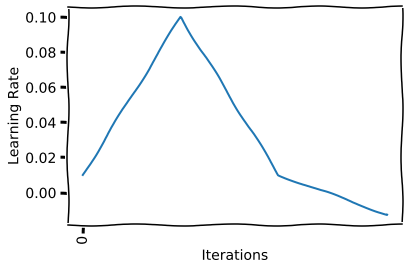

In [57]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=1000), rotation=90)
plt.plot(onecycle.lrs[:9276])
plt.savefig('onecycle_lr.jpg')

In [43]:
# import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# n_epochs = 50
# log_report = LogReport(dirpath=outdir)
# n_train_call = [0]
# min_val_loss = 1e10
# max_val_recall = 0

# for l1 in range(4):
# #     print(l1)
#     indices = [l1] #if debug else [0, 1, 2, 3]
#     train_images = prepare_image(
#         datadir, featherdir, data_type='train', submission=False, indices=indices)
#     each_part_num = 50210
#     train_labels = train_labels_total[(l1*each_part_num):((l1+1)*each_part_num)]
    
#     n_dataset = len(train_images)
#     train_data_size = 200 if debug else int(n_dataset * 0.9)
#     valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#     perm = np.random.RandomState(777).permutation(n_dataset)
#     train_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#         indices=perm[:train_data_size])
#     valid_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#         indices=perm[train_data_size:train_data_size+valid_data_size])
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
#     for epoch in range(n_epochs):
#         torch.cuda.empty_cache()
#         gc.collect()
#         train_metrics = train_model(epoch, train_loader, log_report)
#         val_metrics = evaluate_model(epoch, valid_loader, log_report)
#         mode, min_val_loss, max_val_recall = save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall)
# #         print("min_val_loss = ", min_val_loss)
# #         print("max_val_recall = ", max_val_recall)
#         log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)            

image_df_list 1


  0%|          | 0/1413 [00:00<?, ?it/s]/home/chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      0 train/loss  6.197148 train/loss_grapheme  4.122949 train/loss_vowel  1.050849 train/loss_consonant  1.023350 train/acc_grapheme  0.129611 train/acc_vowel  0.726925 train/acc_consonant  0.735444 train/recall  0.344857 val/loss  3.629249 val/loss_grapheme  2.694033 val/loss_vowel  0.459567 val/loss_consonant  0.475648 val/acc_grapheme  0.372834 val/acc_vowel  0.890659 val/acc_consonant  0.894045 val/recall  0.534402 lr  0.001000 elapsed_time  210.125095 mode 111 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      1 train/loss  3.184163 train/loss_grapheme  2.317021 train/loss_vowel  0.463079 train/loss_consonant  0.404063 train/acc_grapheme  0.449733 train/acc_vowel  0.880325 train/acc_consonant  0.895218 train/recall  0.572855 val/loss  1.773301 val/loss_grapheme  1.246082 val/loss_vowel  0.259089 val/loss_consonant  0.268129 val/acc_grapheme  0.694881 val/acc_vowel  0.931089 val/acc_consonant  0.924716 val/recall  0.724462 lr  0.001000 elapsed_time  417.770207 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      2 train/loss  2.078043 train/loss_grapheme  1.504206 train/loss_vowel  0.310046 train/loss_consonant  0.263791 train/acc_grapheme  0.638961 train/acc_vowel  0.918918 train/acc_consonant  0.926708 train/recall  0.691265 val/loss  1.221680 val/loss_grapheme  0.827602 val/loss_vowel  0.198018 val/loss_consonant  0.196060 val/acc_grapheme  0.790480 val/acc_vowel  0.950408 val/acc_consonant  0.943438 val/recall  0.799348 lr  0.001000 elapsed_time  624.669834 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      3 train/loss  1.546529 train/loss_grapheme  1.094680 train/loss_vowel  0.243188 train/loss_consonant  0.208661 train/acc_grapheme  0.740778 train/acc_vowel  0.936887 train/acc_consonant  0.941136 train/recall  0.763363 val/loss  0.986280 val/loss_grapheme  0.647465 val/loss_vowel  0.169057 val/loss_consonant  0.169758 val/acc_grapheme  0.828719 val/acc_vowel  0.953197 val/acc_consonant  0.952400 val/recall  0.825588 lr  0.001000 elapsed_time  830.736449 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      4 train/loss  1.231887 train/loss_grapheme  0.861281 train/loss_vowel  0.197962 train/loss_consonant  0.172645 train/acc_grapheme  0.793844 train/acc_vowel  0.948726 train/acc_consonant  0.950298 train/recall  0.806932 val/loss  0.861661 val/loss_grapheme  0.583536 val/loss_vowel  0.141301 val/loss_consonant  0.136824 val/acc_grapheme  0.854810 val/acc_vowel  0.963155 val/acc_consonant  0.960167 val/recall  0.852590 lr  0.001000 elapsed_time  1038.797065 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      5 train/loss  1.011193 train/loss_grapheme  0.697641 train/loss_vowel  0.170056 train/loss_consonant  0.143496 train/acc_grapheme  0.831242 train/acc_vowel  0.955852 train/acc_consonant  0.958286 train/recall  0.837686 val/loss  0.738193 val/loss_grapheme  0.490420 val/loss_vowel  0.122406 val/loss_consonant  0.125367 val/acc_grapheme  0.875722 val/acc_vowel  0.966939 val/acc_consonant  0.967935 val/recall  0.869108 lr  0.001000 elapsed_time  1245.792332 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      6 train/loss  0.860338 train/loss_grapheme  0.589883 train/loss_vowel  0.139662 train/loss_consonant  0.130792 train/acc_grapheme  0.854411 train/acc_vowel  0.962911 train/acc_consonant  0.961716 train/recall  0.857735 val/loss  0.750918 val/loss_grapheme  0.490853 val/loss_vowel  0.141872 val/loss_consonant  0.118193 val/acc_grapheme  0.876519 val/acc_vowel  0.960765 val/acc_consonant  0.965744 val/recall  0.869014 lr  0.001000 elapsed_time  1448.900907 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      7 train/loss  0.761555 train/loss_grapheme  0.514621 train/loss_vowel  0.130017 train/loss_consonant  0.116917 train/acc_grapheme  0.874151 train/acc_vowel  0.966032 train/acc_consonant  0.966120 train/recall  0.876070 val/loss  0.734049 val/loss_grapheme  0.480994 val/loss_vowel  0.132977 val/loss_consonant  0.120078 val/acc_grapheme  0.881697 val/acc_vowel  0.963155 val/acc_consonant  0.964748 val/recall  0.875174 lr  0.001000 elapsed_time  1651.853332 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      8 train/loss  0.667487 train/loss_grapheme  0.450753 train/loss_vowel  0.114310 train/loss_consonant  0.102425 train/acc_grapheme  0.885392 train/acc_vowel  0.969130 train/acc_consonant  0.969572 train/recall  0.886147 val/loss  0.707486 val/loss_grapheme  0.464462 val/loss_vowel  0.126689 val/loss_consonant  0.116335 val/acc_grapheme  0.887473 val/acc_vowel  0.967337 val/acc_consonant  0.966740 val/recall  0.875970 lr  0.001000 elapsed_time  1858.590589 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      9 train/loss  0.612451 train/loss_grapheme  0.411221 train/loss_vowel  0.104490 train/loss_consonant  0.096740 train/acc_grapheme  0.894333 train/acc_vowel  0.971896 train/acc_consonant  0.971984 train/recall  0.894443 val/loss  0.634092 val/loss_grapheme  0.415847 val/loss_vowel  0.111244 val/loss_consonant  0.107001 val/acc_grapheme  0.898825 val/acc_vowel  0.970922 val/acc_consonant  0.968930 val/recall  0.889286 lr  0.001000 elapsed_time  2064.186748 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     10 train/loss  0.553820 train/loss_grapheme  0.369107 train/loss_vowel  0.096571 train/loss_consonant  0.088142 train/acc_grapheme  0.903494 train/acc_vowel  0.973224 train/acc_consonant  0.973201 train/recall  0.903186 val/loss  0.624528 val/loss_grapheme  0.414274 val/loss_vowel  0.102127 val/loss_consonant  0.108126 val/acc_grapheme  0.901613 val/acc_vowel  0.972715 val/acc_consonant  0.970524 val/recall  0.896369 lr  0.001000 elapsed_time  2270.690785 mode 111 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     11 train/loss  0.504873 train/loss_grapheme  0.334895 train/loss_vowel  0.087418 train/loss_consonant  0.082560 train/acc_grapheme  0.911903 train/acc_vowel  0.977229 train/acc_consonant  0.975215 train/recall  0.910943 val/loss  0.654015 val/loss_grapheme  0.426897 val/loss_vowel  0.114554 val/loss_consonant  0.112565 val/acc_grapheme  0.903804 val/acc_vowel  0.970325 val/acc_consonant  0.970524 val/recall  0.895749 lr  0.001000 elapsed_time  2476.890082 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     12 train/loss  0.461847 train/loss_grapheme  0.306176 train/loss_vowel  0.081225 train/loss_consonant  0.074446 train/acc_grapheme  0.920556 train/acc_vowel  0.977937 train/acc_consonant  0.977760 train/recall  0.917708 val/loss  0.604741 val/loss_grapheme  0.395945 val/loss_vowel  0.099473 val/loss_consonant  0.109322 val/acc_grapheme  0.910376 val/acc_vowel  0.974706 val/acc_consonant  0.970524 val/recall  0.903352 lr  0.001000 elapsed_time  2684.874238 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     13 train/loss  0.426307 train/loss_grapheme  0.280887 train/loss_vowel  0.076259 train/loss_consonant  0.069161 train/acc_grapheme  0.926575 train/acc_vowel  0.978955 train/acc_consonant  0.978734 train/recall  0.923702 val/loss  0.608880 val/loss_grapheme  0.405444 val/loss_vowel  0.094351 val/loss_consonant  0.109085 val/acc_grapheme  0.907986 val/acc_vowel  0.974308 val/acc_consonant  0.972117 val/recall  0.899888 lr  0.001000 elapsed_time  2891.684289 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     14 train/loss  0.406219 train/loss_grapheme  0.267124 train/loss_vowel  0.072310 train/loss_consonant  0.066786 train/acc_grapheme  0.929031 train/acc_vowel  0.980283 train/acc_consonant  0.979973 train/recall  0.926697 val/loss  0.631250 val/loss_grapheme  0.412704 val/loss_vowel  0.107715 val/loss_consonant  0.110831 val/acc_grapheme  0.904800 val/acc_vowel  0.971719 val/acc_consonant  0.970723 val/recall  0.896551 lr  0.001000 elapsed_time  3098.215092 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     15 train/loss  0.370198 train/loss_grapheme  0.244536 train/loss_vowel  0.064729 train/loss_consonant  0.060933 train/acc_grapheme  0.934453 train/acc_vowel  0.981411 train/acc_consonant  0.981987 train/recall  0.932016 val/loss  0.595763 val/loss_grapheme  0.387163 val/loss_vowel  0.100600 val/loss_consonant  0.108000 val/acc_grapheme  0.914360 val/acc_vowel  0.974109 val/acc_consonant  0.970524 val/recall  0.904897 lr  0.001000 elapsed_time  3306.014856 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     16 train/loss  0.350027 train/loss_grapheme  0.229909 train/loss_vowel  0.061787 train/loss_consonant  0.058331 train/acc_grapheme  0.939167 train/acc_vowel  0.982739 train/acc_consonant  0.983093 train/recall  0.936309 val/loss  0.614547 val/loss_grapheme  0.400216 val/loss_vowel  0.102963 val/loss_consonant  0.111368 val/acc_grapheme  0.912567 val/acc_vowel  0.975901 val/acc_consonant  0.973710 val/recall  0.905094 lr  0.001000 elapsed_time  3511.714122 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     17 train/loss  0.327188 train/loss_grapheme  0.217409 train/loss_vowel  0.056677 train/loss_consonant  0.053103 train/acc_grapheme  0.941756 train/acc_vowel  0.984532 train/acc_consonant  0.984421 train/recall  0.940436 val/loss  0.661593 val/loss_grapheme  0.441749 val/loss_vowel  0.120760 val/loss_consonant  0.099084 val/acc_grapheme  0.907588 val/acc_vowel  0.972715 val/acc_consonant  0.975304 val/recall  0.901285 lr  0.001000 elapsed_time  3716.116534 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     18 train/loss  0.306936 train/loss_grapheme  0.201972 train/loss_vowel  0.053220 train/loss_consonant  0.051745 train/acc_grapheme  0.945584 train/acc_vowel  0.984819 train/acc_consonant  0.984355 train/recall  0.943001 val/loss  0.611653 val/loss_grapheme  0.410859 val/loss_vowel  0.102575 val/loss_consonant  0.098219 val/acc_grapheme  0.911571 val/acc_vowel  0.972715 val/acc_consonant  0.973710 val/recall  0.905651 lr  0.001000 elapsed_time  3921.908394 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     19 train/loss  0.294007 train/loss_grapheme  0.192868 train/loss_vowel  0.052814 train/loss_consonant  0.048325 train/acc_grapheme  0.947841 train/acc_vowel  0.985151 train/acc_consonant  0.985483 train/recall  0.945434 val/loss  0.635212 val/loss_grapheme  0.417866 val/loss_vowel  0.107208 val/loss_consonant  0.110137 val/acc_grapheme  0.905397 val/acc_vowel  0.973710 val/acc_consonant  0.973910 val/recall  0.897267 lr  0.001000 elapsed_time  4128.366115 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     20 train/loss  0.268204 train/loss_grapheme  0.175995 train/loss_vowel  0.048914 train/loss_consonant  0.043295 train/acc_grapheme  0.952665 train/acc_vowel  0.985727 train/acc_consonant  0.986877 train/recall  0.950401 val/loss  0.680041 val/loss_grapheme  0.446094 val/loss_vowel  0.106782 val/loss_consonant  0.127166 val/acc_grapheme  0.900817 val/acc_vowel  0.973312 val/acc_consonant  0.967138 val/recall  0.891827 lr  0.001000 elapsed_time  4335.033884 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     21 train/loss  0.259254 train/loss_grapheme  0.171298 train/loss_vowel  0.045010 train/loss_consonant  0.042946 train/acc_grapheme  0.953396 train/acc_vowel  0.987829 train/acc_consonant  0.986944 train/recall  0.952182 val/loss  0.636439 val/loss_grapheme  0.408781 val/loss_vowel  0.118065 val/loss_consonant  0.109593 val/acc_grapheme  0.913762 val/acc_vowel  0.970325 val/acc_consonant  0.971918 val/recall  0.903774 lr  0.001000 elapsed_time  4541.450616 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     22 train/loss  0.247683 train/loss_grapheme  0.159954 train/loss_vowel  0.043500 train/loss_consonant  0.044229 train/acc_grapheme  0.957268 train/acc_vowel  0.987785 train/acc_consonant  0.986745 train/recall  0.954867 val/loss  0.585818 val/loss_grapheme  0.381331 val/loss_vowel  0.104378 val/loss_consonant  0.100109 val/acc_grapheme  0.914161 val/acc_vowel  0.972914 val/acc_consonant  0.973312 val/recall  0.905781 lr  0.001000 elapsed_time  4748.572195 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     23 train/loss  0.241491 train/loss_grapheme  0.155482 train/loss_vowel  0.043607 train/loss_consonant  0.042402 train/acc_grapheme  0.956959 train/acc_vowel  0.987077 train/acc_consonant  0.986988 train/recall  0.954417 val/loss  0.630242 val/loss_grapheme  0.400152 val/loss_vowel  0.113505 val/loss_consonant  0.116585 val/acc_grapheme  0.912766 val/acc_vowel  0.972316 val/acc_consonant  0.971719 val/recall  0.904834 lr  0.001000 elapsed_time  4955.230510 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     24 train/loss  0.228594 train/loss_grapheme  0.149672 train/loss_vowel  0.041313 train/loss_consonant  0.037609 train/acc_grapheme  0.958640 train/acc_vowel  0.988249 train/acc_consonant  0.988316 train/recall  0.956701 val/loss  0.655945 val/loss_grapheme  0.428991 val/loss_vowel  0.112730 val/loss_consonant  0.114224 val/acc_grapheme  0.912567 val/acc_vowel  0.971121 val/acc_consonant  0.968731 val/recall  0.899639 lr  0.001000 elapsed_time  5162.705724 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     25 train/loss  0.222286 train/loss_grapheme  0.143329 train/loss_vowel  0.040666 train/loss_consonant  0.038290 train/acc_grapheme  0.960831 train/acc_vowel  0.988050 train/acc_consonant  0.987917 train/recall  0.957994 val/loss  0.635526 val/loss_grapheme  0.420073 val/loss_vowel  0.110475 val/loss_consonant  0.104978 val/acc_grapheme  0.912368 val/acc_vowel  0.974507 val/acc_consonant  0.975304 val/recall  0.905205 lr  0.001000 elapsed_time  5362.063158 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     26 train/loss  0.200514 train/loss_grapheme  0.134403 train/loss_vowel  0.035796 train/loss_consonant  0.030315 train/acc_grapheme  0.962048 train/acc_vowel  0.989798 train/acc_consonant  0.990861 train/recall  0.960967 val/loss  0.634154 val/loss_grapheme  0.414594 val/loss_vowel  0.119363 val/loss_consonant  0.100196 val/acc_grapheme  0.917745 val/acc_vowel  0.974706 val/acc_consonant  0.975702 val/recall  0.910276 lr  0.001000 elapsed_time  5567.658222 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     27 train/loss  0.200349 train/loss_grapheme  0.131091 train/loss_vowel  0.035695 train/loss_consonant  0.033563 train/acc_grapheme  0.963265 train/acc_vowel  0.989312 train/acc_consonant  0.989621 train/recall  0.960851 val/loss  0.596468 val/loss_grapheme  0.402768 val/loss_vowel  0.098330 val/loss_consonant  0.095370 val/acc_grapheme  0.916750 val/acc_vowel  0.976300 val/acc_consonant  0.977295 val/recall  0.910158 lr  0.001000 elapsed_time  5774.432899 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     28 train/loss  0.199990 train/loss_grapheme  0.131800 train/loss_vowel  0.035252 train/loss_consonant  0.032937 train/acc_grapheme  0.963022 train/acc_vowel  0.989599 train/acc_consonant  0.989975 train/recall  0.961883 val/loss  0.612967 val/loss_grapheme  0.406748 val/loss_vowel  0.104929 val/loss_consonant  0.101290 val/acc_grapheme  0.916550 val/acc_vowel  0.975503 val/acc_consonant  0.977694 val/recall  0.910396 lr  0.001000 elapsed_time  5981.157912 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     29 train/loss  0.186422 train/loss_grapheme  0.121626 train/loss_vowel  0.034598 train/loss_consonant  0.030198 train/acc_grapheme  0.966740 train/acc_vowel  0.990064 train/acc_consonant  0.990484 train/recall  0.965142 val/loss  0.629356 val/loss_grapheme  0.421087 val/loss_vowel  0.106167 val/loss_consonant  0.102103 val/acc_grapheme  0.915156 val/acc_vowel  0.975901 val/acc_consonant  0.976100 val/recall  0.908797 lr  0.001000 elapsed_time  6188.614521 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     30 train/loss  0.171987 train/loss_grapheme  0.111627 train/loss_vowel  0.031082 train/loss_consonant  0.029278 train/acc_grapheme  0.969439 train/acc_vowel  0.991193 train/acc_consonant  0.991148 train/recall  0.967842 val/loss  0.631792 val/loss_grapheme  0.406154 val/loss_vowel  0.110872 val/loss_consonant  0.114766 val/acc_grapheme  0.915555 val/acc_vowel  0.975105 val/acc_consonant  0.971719 val/recall  0.908943 lr  0.001000 elapsed_time  6394.422621 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     31 train/loss  0.172168 train/loss_grapheme  0.109945 train/loss_vowel  0.031619 train/loss_consonant  0.030604 train/acc_grapheme  0.970524 train/acc_vowel  0.991060 train/acc_consonant  0.990551 train/recall  0.968022 val/loss  0.663823 val/loss_grapheme  0.433250 val/loss_vowel  0.119977 val/loss_consonant  0.110597 val/acc_grapheme  0.918741 val/acc_vowel  0.972715 val/acc_consonant  0.974308 val/recall  0.909333 lr  0.001000 elapsed_time  6600.534981 mode 000 


100%|██████████| 157/157 [00:10<00:00, 15.45it/s]


epoch     32 train/loss  0.175646 train/loss_grapheme  0.113688 train/loss_vowel  0.029801 train/loss_consonant  0.032157 train/acc_grapheme  0.968820 train/acc_vowel  0.991370 train/acc_consonant  0.990241 train/recall  0.967128 val/loss  0.639773 val/loss_grapheme  0.420033 val/loss_vowel  0.106306 val/loss_consonant  0.113435 val/acc_grapheme  0.915156 val/acc_vowel  0.976300 val/acc_consonant  0.974706 val/recall  0.905115 lr  0.001000 elapsed_time  6806.775904 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     33 train/loss  0.160927 train/loss_grapheme  0.104253 train/loss_vowel  0.029939 train/loss_consonant  0.026735 train/acc_grapheme  0.971564 train/acc_vowel  0.991060 train/acc_consonant  0.992033 train/recall  0.969737 val/loss  0.623424 val/loss_grapheme  0.424995 val/loss_vowel  0.098460 val/loss_consonant  0.099969 val/acc_grapheme  0.916351 val/acc_vowel  0.978889 val/acc_consonant  0.977096 val/recall  0.911637 lr  0.001000 elapsed_time  7013.807950 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     34 train/loss  0.155978 train/loss_grapheme  0.101900 train/loss_vowel  0.027085 train/loss_consonant  0.026994 train/acc_grapheme  0.971077 train/acc_vowel  0.992454 train/acc_consonant  0.991613 train/recall  0.969891 val/loss  0.669366 val/loss_grapheme  0.442465 val/loss_vowel  0.120877 val/loss_consonant  0.106024 val/acc_grapheme  0.911771 val/acc_vowel  0.972914 val/acc_consonant  0.974109 val/recall  0.905205 lr  0.001000 elapsed_time  7220.415594 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     35 train/loss  0.155723 train/loss_grapheme  0.102437 train/loss_vowel  0.027936 train/loss_consonant  0.025350 train/acc_grapheme  0.971343 train/acc_vowel  0.991834 train/acc_consonant  0.992255 train/recall  0.969803 val/loss  0.642772 val/loss_grapheme  0.419058 val/loss_vowel  0.110273 val/loss_consonant  0.113441 val/acc_grapheme  0.914957 val/acc_vowel  0.973710 val/acc_consonant  0.973312 val/recall  0.907561 lr  0.001000 elapsed_time  7427.485757 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     36 train/loss  0.150168 train/loss_grapheme  0.096118 train/loss_vowel  0.028050 train/loss_consonant  0.026000 train/acc_grapheme  0.973887 train/acc_vowel  0.992255 train/acc_consonant  0.992255 train/recall  0.973036 val/loss  0.635987 val/loss_grapheme  0.418730 val/loss_vowel  0.108905 val/loss_consonant  0.108353 val/acc_grapheme  0.917945 val/acc_vowel  0.974507 val/acc_consonant  0.974706 val/recall  0.909796 lr  0.001000 elapsed_time  7633.862732 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     37 train/loss  0.149466 train/loss_grapheme  0.096084 train/loss_vowel  0.026838 train/loss_consonant  0.026543 train/acc_grapheme  0.973401 train/acc_vowel  0.992210 train/acc_consonant  0.992100 train/recall  0.972008 val/loss  0.633496 val/loss_grapheme  0.409225 val/loss_vowel  0.110753 val/loss_consonant  0.113518 val/acc_grapheme  0.920135 val/acc_vowel  0.974706 val/acc_consonant  0.973910 val/recall  0.912607 lr  0.001000 elapsed_time  7840.235311 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     38 train/loss  0.144658 train/loss_grapheme  0.093285 train/loss_vowel  0.026430 train/loss_consonant  0.024943 train/acc_grapheme  0.974773 train/acc_vowel  0.992454 train/acc_consonant  0.992277 train/recall  0.973356 val/loss  0.688667 val/loss_grapheme  0.450723 val/loss_vowel  0.111342 val/loss_consonant  0.126602 val/acc_grapheme  0.914559 val/acc_vowel  0.975105 val/acc_consonant  0.973113 val/recall  0.906066 lr  0.001000 elapsed_time  8046.484890 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     39 train/loss  0.138260 train/loss_grapheme  0.090021 train/loss_vowel  0.023901 train/loss_consonant  0.024338 train/acc_grapheme  0.974463 train/acc_vowel  0.993096 train/acc_consonant  0.992122 train/recall  0.972730 val/loss  0.694888 val/loss_grapheme  0.449461 val/loss_vowel  0.118598 val/loss_consonant  0.126829 val/acc_grapheme  0.914161 val/acc_vowel  0.976300 val/acc_consonant  0.975702 val/recall  0.908248 lr  0.001000 elapsed_time  8253.006078 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     40 train/loss  0.139325 train/loss_grapheme  0.088486 train/loss_vowel  0.025432 train/loss_consonant  0.025408 train/acc_grapheme  0.975038 train/acc_vowel  0.992963 train/acc_consonant  0.992210 train/recall  0.973330 val/loss  0.637441 val/loss_grapheme  0.416688 val/loss_vowel  0.117058 val/loss_consonant  0.103696 val/acc_grapheme  0.919538 val/acc_vowel  0.973710 val/acc_consonant  0.975304 val/recall  0.912767 lr  0.001000 elapsed_time  8459.578282 mode 101 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     41 train/loss  0.135462 train/loss_grapheme  0.088425 train/loss_vowel  0.024386 train/loss_consonant  0.022651 train/acc_grapheme  0.975326 train/acc_vowel  0.992919 train/acc_consonant  0.993295 train/recall  0.973742 val/loss  0.667159 val/loss_grapheme  0.451644 val/loss_vowel  0.105337 val/loss_consonant  0.110178 val/acc_grapheme  0.915754 val/acc_vowel  0.975304 val/acc_consonant  0.976100 val/recall  0.908137 lr  0.001000 elapsed_time  8663.877542 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     42 train/loss  0.119811 train/loss_grapheme  0.077648 train/loss_vowel  0.021576 train/loss_consonant  0.020587 train/acc_grapheme  0.978446 train/acc_vowel  0.993937 train/acc_consonant  0.993538 train/recall  0.977149 val/loss  0.638678 val/loss_grapheme  0.422196 val/loss_vowel  0.100199 val/loss_consonant  0.116283 val/acc_grapheme  0.916750 val/acc_vowel  0.977295 val/acc_consonant  0.975503 val/recall  0.911501 lr  0.001000 elapsed_time  8863.640233 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     43 train/loss  0.135180 train/loss_grapheme  0.083094 train/loss_vowel  0.027430 train/loss_consonant  0.024656 train/acc_grapheme  0.976786 train/acc_vowel  0.992144 train/acc_consonant  0.992255 train/recall  0.974655 val/loss  0.616531 val/loss_grapheme  0.395759 val/loss_vowel  0.109219 val/loss_consonant  0.111553 val/acc_grapheme  0.924119 val/acc_vowel  0.976300 val/acc_consonant  0.974109 val/recall  0.914340 lr  0.001000 elapsed_time  9069.862282 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     44 train/loss  0.124249 train/loss_grapheme  0.079587 train/loss_vowel  0.023754 train/loss_consonant  0.020908 train/acc_grapheme  0.978092 train/acc_vowel  0.993383 train/acc_consonant  0.993428 train/recall  0.976632 val/loss  0.633102 val/loss_grapheme  0.416536 val/loss_vowel  0.104989 val/loss_consonant  0.111577 val/acc_grapheme  0.913762 val/acc_vowel  0.976698 val/acc_consonant  0.977495 val/recall  0.908872 lr  0.001000 elapsed_time  9275.583794 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     45 train/loss  0.119637 train/loss_grapheme  0.078733 train/loss_vowel  0.021257 train/loss_consonant  0.019647 train/acc_grapheme  0.977760 train/acc_vowel  0.993826 train/acc_consonant  0.994114 train/recall  0.976925 val/loss  0.606412 val/loss_grapheme  0.392343 val/loss_vowel  0.104199 val/loss_consonant  0.109870 val/acc_grapheme  0.922127 val/acc_vowel  0.976698 val/acc_consonant  0.975702 val/recall  0.914542 lr  0.001000 elapsed_time  9482.499487 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     46 train/loss  0.120740 train/loss_grapheme  0.077952 train/loss_vowel  0.022949 train/loss_consonant  0.019840 train/acc_grapheme  0.979132 train/acc_vowel  0.993583 train/acc_consonant  0.994025 train/recall  0.977987 val/loss  0.687298 val/loss_grapheme  0.441154 val/loss_vowel  0.125305 val/loss_consonant  0.120839 val/acc_grapheme  0.914758 val/acc_vowel  0.972515 val/acc_consonant  0.972515 val/recall  0.905827 lr  0.001000 elapsed_time  9687.922316 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     47 train/loss  0.115246 train/loss_grapheme  0.074343 train/loss_vowel  0.021509 train/loss_consonant  0.019394 train/acc_grapheme  0.979398 train/acc_vowel  0.993715 train/acc_consonant  0.993782 train/recall  0.977623 val/loss  0.618699 val/loss_grapheme  0.410944 val/loss_vowel  0.107863 val/loss_consonant  0.099892 val/acc_grapheme  0.917546 val/acc_vowel  0.975304 val/acc_consonant  0.976897 val/recall  0.909449 lr  0.001000 elapsed_time  9894.589015 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     48 train/loss  0.109528 train/loss_grapheme  0.072953 train/loss_vowel  0.018871 train/loss_consonant  0.017704 train/acc_grapheme  0.979597 train/acc_vowel  0.994512 train/acc_consonant  0.994755 train/recall  0.979046 val/loss  0.632398 val/loss_grapheme  0.419052 val/loss_vowel  0.111628 val/loss_consonant  0.101718 val/acc_grapheme  0.920135 val/acc_vowel  0.973511 val/acc_consonant  0.976698 val/recall  0.913672 lr  0.001000 elapsed_time  10101.565718 mode 000 


100%|██████████| 157/157 [00:10<00:00, 15.32it/s]


epoch     49 train/loss  0.115856 train/loss_grapheme  0.075309 train/loss_vowel  0.021529 train/loss_consonant  0.019018 train/acc_grapheme  0.978955 train/acc_vowel  0.993760 train/acc_consonant  0.994202 train/recall  0.977849 val/loss  0.624876 val/loss_grapheme  0.397069 val/loss_vowel  0.120538 val/loss_consonant  0.107268 val/acc_grapheme  0.920335 val/acc_vowel  0.974905 val/acc_consonant  0.974507 val/recall  0.912363 lr  0.001000 elapsed_time  10307.968267 mode 000 
image_df_list 1


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      0 train/loss  0.628521 train/loss_grapheme  0.396856 train/loss_vowel  0.119226 train/loss_consonant  0.112439 train/acc_grapheme  0.901657 train/acc_vowel  0.969484 train/acc_consonant  0.968997 train/recall  0.895516 val/loss  0.435054 val/loss_grapheme  0.291813 val/loss_vowel  0.074075 val/loss_consonant  0.069166 val/acc_grapheme  0.929297 val/acc_vowel  0.982872 val/acc_consonant  0.978889 val/recall  0.920568 lr  0.001000 elapsed_time  10515.672734 mode 111 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      1 train/loss  0.417577 train/loss_grapheme  0.268801 train/loss_vowel  0.075399 train/loss_consonant  0.073377 train/acc_grapheme  0.926619 train/acc_vowel  0.979021 train/acc_consonant  0.979553 train/recall  0.923336 val/loss  0.453244 val/loss_grapheme  0.290364 val/loss_vowel  0.087112 val/loss_consonant  0.075768 val/acc_grapheme  0.925115 val/acc_vowel  0.977893 val/acc_consonant  0.979287 val/recall  0.916483 lr  0.001000 elapsed_time  10722.489015 mode 000 


100%|██████████| 157/157 [00:10<00:00, 14.58it/s]


epoch      2 train/loss  0.345933 train/loss_grapheme  0.221366 train/loss_vowel  0.066280 train/loss_consonant  0.058287 train/acc_grapheme  0.937374 train/acc_vowel  0.981345 train/acc_consonant  0.982120 train/recall  0.933420 val/loss  0.427571 val/loss_grapheme  0.273151 val/loss_vowel  0.084541 val/loss_consonant  0.069880 val/acc_grapheme  0.928301 val/acc_vowel  0.977495 val/acc_consonant  0.979088 val/recall  0.918167 lr  0.001000 elapsed_time  10929.783312 mode 010 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      3 train/loss  0.297618 train/loss_grapheme  0.190029 train/loss_vowel  0.055263 train/loss_consonant  0.052327 train/acc_grapheme  0.945960 train/acc_vowel  0.984952 train/acc_consonant  0.983669 train/recall  0.943135 val/loss  0.439389 val/loss_grapheme  0.279352 val/loss_vowel  0.079252 val/loss_consonant  0.080785 val/acc_grapheme  0.924517 val/acc_vowel  0.980681 val/acc_consonant  0.976499 val/recall  0.915672 lr  0.001000 elapsed_time  11139.345715 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      4 train/loss  0.270180 train/loss_grapheme  0.172650 train/loss_vowel  0.049795 train/loss_consonant  0.047735 train/acc_grapheme  0.949877 train/acc_vowel  0.985638 train/acc_consonant  0.985328 train/recall  0.947564 val/loss  0.461939 val/loss_grapheme  0.303829 val/loss_vowel  0.081082 val/loss_consonant  0.077028 val/acc_grapheme  0.927903 val/acc_vowel  0.981478 val/acc_consonant  0.976499 val/recall  0.916044 lr  0.001000 elapsed_time  11348.247996 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      5 train/loss  0.196787 train/loss_grapheme  0.124506 train/loss_vowel  0.036300 train/loss_consonant  0.035981 train/acc_grapheme  0.963885 train/acc_vowel  0.988957 train/acc_consonant  0.989356 train/recall  0.960830 val/loss  0.448246 val/loss_grapheme  0.283510 val/loss_vowel  0.083049 val/loss_consonant  0.081687 val/acc_grapheme  0.933081 val/acc_vowel  0.982075 val/acc_consonant  0.977893 val/recall  0.922135 lr  0.000700 elapsed_time  11555.061094 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      6 train/loss  0.172933 train/loss_grapheme  0.112410 train/loss_vowel  0.030989 train/loss_consonant  0.029534 train/acc_grapheme  0.967913 train/acc_vowel  0.990684 train/acc_consonant  0.991082 train/recall  0.966106 val/loss  0.440807 val/loss_grapheme  0.285739 val/loss_vowel  0.078118 val/loss_consonant  0.076949 val/acc_grapheme  0.935073 val/acc_vowel  0.982474 val/acc_consonant  0.980283 val/recall  0.927610 lr  0.000700 elapsed_time  11763.206065 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      7 train/loss  0.156768 train/loss_grapheme  0.102189 train/loss_vowel  0.027330 train/loss_consonant  0.027249 train/acc_grapheme  0.969749 train/acc_vowel  0.991945 train/acc_consonant  0.991259 train/recall  0.968117 val/loss  0.431311 val/loss_grapheme  0.283501 val/loss_vowel  0.074187 val/loss_consonant  0.073623 val/acc_grapheme  0.932484 val/acc_vowel  0.983469 val/acc_consonant  0.979287 val/recall  0.925120 lr  0.000700 elapsed_time  11970.730695 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      8 train/loss  0.146263 train/loss_grapheme  0.094364 train/loss_vowel  0.026334 train/loss_consonant  0.025565 train/acc_grapheme  0.971608 train/acc_vowel  0.992565 train/acc_consonant  0.991879 train/recall  0.970022 val/loss  0.441034 val/loss_grapheme  0.275034 val/loss_vowel  0.084187 val/loss_consonant  0.081813 val/acc_grapheme  0.934475 val/acc_vowel  0.981279 val/acc_consonant  0.979088 val/recall  0.924825 lr  0.000700 elapsed_time  12179.174029 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      9 train/loss  0.135896 train/loss_grapheme  0.089113 train/loss_vowel  0.024478 train/loss_consonant  0.022305 train/acc_grapheme  0.974441 train/acc_vowel  0.992697 train/acc_consonant  0.992897 train/recall  0.973180 val/loss  0.466444 val/loss_grapheme  0.294182 val/loss_vowel  0.089593 val/loss_consonant  0.082668 val/acc_grapheme  0.935471 val/acc_vowel  0.979088 val/acc_consonant  0.978092 val/recall  0.923613 lr  0.000700 elapsed_time  12388.092110 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     10 train/loss  0.125349 train/loss_grapheme  0.081957 train/loss_vowel  0.023499 train/loss_consonant  0.019893 train/acc_grapheme  0.976255 train/acc_vowel  0.992520 train/acc_consonant  0.994246 train/recall  0.975804 val/loss  0.468033 val/loss_grapheme  0.299425 val/loss_vowel  0.083882 val/loss_consonant  0.084726 val/acc_grapheme  0.934276 val/acc_vowel  0.983669 val/acc_consonant  0.977694 val/recall  0.925096 lr  0.000700 elapsed_time  12595.292987 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     11 train/loss  0.091511 train/loss_grapheme  0.060069 train/loss_vowel  0.017052 train/loss_consonant  0.014389 train/acc_grapheme  0.983027 train/acc_vowel  0.995109 train/acc_consonant  0.995618 train/recall  0.982032 val/loss  0.450157 val/loss_grapheme  0.277432 val/loss_vowel  0.085485 val/loss_consonant  0.087240 val/acc_grapheme  0.936268 val/acc_vowel  0.981279 val/acc_consonant  0.979287 val/recall  0.926757 lr  0.000490 elapsed_time  12801.231128 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     12 train/loss  0.082256 train/loss_grapheme  0.053061 train/loss_vowel  0.014511 train/loss_consonant  0.014683 train/acc_grapheme  0.985704 train/acc_vowel  0.995928 train/acc_consonant  0.995862 train/recall  0.985149 val/loss  0.464031 val/loss_grapheme  0.291640 val/loss_vowel  0.087305 val/loss_consonant  0.085087 val/acc_grapheme  0.934077 val/acc_vowel  0.982673 val/acc_consonant  0.980880 val/recall  0.926970 lr  0.000490 elapsed_time  13009.262012 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     13 train/loss  0.075834 train/loss_grapheme  0.049273 train/loss_vowel  0.013827 train/loss_consonant  0.012734 train/acc_grapheme  0.985904 train/acc_vowel  0.996127 train/acc_consonant  0.996371 train/recall  0.985540 val/loss  0.483889 val/loss_grapheme  0.291265 val/loss_vowel  0.088073 val/loss_consonant  0.104551 val/acc_grapheme  0.938259 val/acc_vowel  0.982075 val/acc_consonant  0.977893 val/recall  0.927796 lr  0.000490 elapsed_time  13216.039096 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     14 train/loss  0.076316 train/loss_grapheme  0.049458 train/loss_vowel  0.013935 train/loss_consonant  0.012923 train/acc_grapheme  0.986125 train/acc_vowel  0.996017 train/acc_consonant  0.996105 train/recall  0.986006 val/loss  0.476167 val/loss_grapheme  0.306721 val/loss_vowel  0.082171 val/loss_consonant  0.087275 val/acc_grapheme  0.940052 val/acc_vowel  0.982872 val/acc_consonant  0.978490 val/recall  0.929960 lr  0.000490 elapsed_time  13423.546132 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     15 train/loss  0.069353 train/loss_grapheme  0.045620 train/loss_vowel  0.010497 train/loss_consonant  0.013236 train/acc_grapheme  0.987143 train/acc_vowel  0.997234 train/acc_consonant  0.996437 train/recall  0.986886 val/loss  0.473206 val/loss_grapheme  0.288078 val/loss_vowel  0.092881 val/loss_consonant  0.092247 val/acc_grapheme  0.938458 val/acc_vowel  0.981079 val/acc_consonant  0.977096 val/recall  0.927465 lr  0.000490 elapsed_time  13630.123798 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     16 train/loss  0.068016 train/loss_grapheme  0.044108 train/loss_vowel  0.011807 train/loss_consonant  0.012101 train/acc_grapheme  0.987519 train/acc_vowel  0.996614 train/acc_consonant  0.996570 train/recall  0.986804 val/loss  0.463137 val/loss_grapheme  0.283989 val/loss_vowel  0.093055 val/loss_consonant  0.086093 val/acc_grapheme  0.942442 val/acc_vowel  0.981876 val/acc_consonant  0.979088 val/recall  0.930399 lr  0.000490 elapsed_time  13833.118905 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     17 train/loss  0.065284 train/loss_grapheme  0.041193 train/loss_vowel  0.012615 train/loss_consonant  0.011476 train/acc_grapheme  0.988338 train/acc_vowel  0.996282 train/acc_consonant  0.996614 train/recall  0.987846 val/loss  0.481065 val/loss_grapheme  0.306693 val/loss_vowel  0.090980 val/loss_consonant  0.083392 val/acc_grapheme  0.935670 val/acc_vowel  0.983071 val/acc_consonant  0.979088 val/recall  0.927042 lr  0.000490 elapsed_time  14033.365788 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     18 train/loss  0.063269 train/loss_grapheme  0.041090 train/loss_vowel  0.010915 train/loss_consonant  0.011264 train/acc_grapheme  0.988825 train/acc_vowel  0.997035 train/acc_consonant  0.996880 train/recall  0.988757 val/loss  0.470723 val/loss_grapheme  0.303149 val/loss_vowel  0.080707 val/loss_consonant  0.086866 val/acc_grapheme  0.938060 val/acc_vowel  0.984864 val/acc_consonant  0.979287 val/recall  0.930060 lr  0.000490 elapsed_time  14240.252732 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     19 train/loss  0.063120 train/loss_grapheme  0.040953 train/loss_vowel  0.012024 train/loss_consonant  0.010142 train/acc_grapheme  0.988471 train/acc_vowel  0.996481 train/acc_consonant  0.996836 train/recall  0.988452 val/loss  0.475565 val/loss_grapheme  0.301715 val/loss_vowel  0.088398 val/loss_consonant  0.085452 val/acc_grapheme  0.940450 val/acc_vowel  0.984465 val/acc_consonant  0.978690 val/recall  0.929580 lr  0.000490 elapsed_time  14447.398981 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     20 train/loss  0.057409 train/loss_grapheme  0.036983 train/loss_vowel  0.011300 train/loss_consonant  0.009126 train/acc_grapheme  0.990042 train/acc_vowel  0.996703 train/acc_consonant  0.997477 train/recall  0.989580 val/loss  0.480389 val/loss_grapheme  0.303254 val/loss_vowel  0.085884 val/loss_consonant  0.091251 val/acc_grapheme  0.939255 val/acc_vowel  0.983868 val/acc_consonant  0.976897 val/recall  0.929284 lr  0.000490 elapsed_time  14654.704383 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     21 train/loss  0.056887 train/loss_grapheme  0.037094 train/loss_vowel  0.009911 train/loss_consonant  0.009883 train/acc_grapheme  0.989400 train/acc_vowel  0.997477 train/acc_consonant  0.997035 train/recall  0.989459 val/loss  0.498679 val/loss_grapheme  0.327142 val/loss_vowel  0.082519 val/loss_consonant  0.089017 val/acc_grapheme  0.936865 val/acc_vowel  0.982872 val/acc_consonant  0.977893 val/recall  0.926428 lr  0.000490 elapsed_time  14862.354458 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     22 train/loss  0.055305 train/loss_grapheme  0.035064 train/loss_vowel  0.010098 train/loss_consonant  0.010143 train/acc_grapheme  0.990462 train/acc_vowel  0.997035 train/acc_consonant  0.996769 train/recall  0.989933 val/loss  0.478423 val/loss_grapheme  0.300574 val/loss_vowel  0.088977 val/loss_consonant  0.088872 val/acc_grapheme  0.938857 val/acc_vowel  0.982872 val/acc_consonant  0.978490 val/recall  0.927460 lr  0.000490 elapsed_time  15069.176942 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     23 train/loss  0.054276 train/loss_grapheme  0.034006 train/loss_vowel  0.010377 train/loss_consonant  0.009893 train/acc_grapheme  0.990706 train/acc_vowel  0.997278 train/acc_consonant  0.997167 train/recall  0.990471 val/loss  0.497420 val/loss_grapheme  0.316410 val/loss_vowel  0.085486 val/loss_consonant  0.095524 val/acc_grapheme  0.935471 val/acc_vowel  0.982872 val/acc_consonant  0.979685 val/recall  0.925147 lr  0.000490 elapsed_time  15275.854264 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     24 train/loss  0.051592 train/loss_grapheme  0.031928 train/loss_vowel  0.009287 train/loss_consonant  0.010377 train/acc_grapheme  0.991524 train/acc_vowel  0.997544 train/acc_consonant  0.997057 train/recall  0.990530 val/loss  0.527794 val/loss_grapheme  0.332609 val/loss_vowel  0.092215 val/loss_consonant  0.102969 val/acc_grapheme  0.934276 val/acc_vowel  0.984465 val/acc_consonant  0.978690 val/recall  0.925856 lr  0.000490 elapsed_time  15483.169884 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     25 train/loss  0.051144 train/loss_grapheme  0.033871 train/loss_vowel  0.009047 train/loss_consonant  0.008226 train/acc_grapheme  0.990883 train/acc_vowel  0.997367 train/acc_consonant  0.997676 train/recall  0.990620 val/loss  0.517056 val/loss_grapheme  0.331050 val/loss_vowel  0.092631 val/loss_consonant  0.093376 val/acc_grapheme  0.938259 val/acc_vowel  0.982474 val/acc_consonant  0.980880 val/recall  0.928635 lr  0.000490 elapsed_time  15689.068366 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     26 train/loss  0.050905 train/loss_grapheme  0.032845 train/loss_vowel  0.008711 train/loss_consonant  0.009348 train/acc_grapheme  0.991237 train/acc_vowel  0.997676 train/acc_consonant  0.997676 train/recall  0.991164 val/loss  0.526048 val/loss_grapheme  0.345249 val/loss_vowel  0.092785 val/loss_consonant  0.088014 val/acc_grapheme  0.935471 val/acc_vowel  0.983669 val/acc_consonant  0.982274 val/recall  0.927049 lr  0.000490 elapsed_time  15896.309471 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     27 train/loss  0.050452 train/loss_grapheme  0.032540 train/loss_vowel  0.008905 train/loss_consonant  0.009007 train/acc_grapheme  0.991303 train/acc_vowel  0.997411 train/acc_consonant  0.997145 train/recall  0.991025 val/loss  0.513283 val/loss_grapheme  0.321754 val/loss_vowel  0.094454 val/loss_consonant  0.097075 val/acc_grapheme  0.938259 val/acc_vowel  0.984266 val/acc_consonant  0.980084 val/recall  0.928831 lr  0.000490 elapsed_time  16103.386899 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     28 train/loss  0.050173 train/loss_grapheme  0.032307 train/loss_vowel  0.008776 train/loss_consonant  0.009090 train/acc_grapheme  0.991303 train/acc_vowel  0.997610 train/acc_consonant  0.997411 train/recall  0.990701 val/loss  0.522088 val/loss_grapheme  0.337090 val/loss_vowel  0.095146 val/loss_consonant  0.089852 val/acc_grapheme  0.937263 val/acc_vowel  0.983270 val/acc_consonant  0.980482 val/recall  0.927638 lr  0.000490 elapsed_time  16310.017113 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     29 train/loss  0.048084 train/loss_grapheme  0.031934 train/loss_vowel  0.007762 train/loss_consonant  0.008388 train/acc_grapheme  0.991635 train/acc_vowel  0.998030 train/acc_consonant  0.997522 train/recall  0.991501 val/loss  0.498847 val/loss_grapheme  0.323242 val/loss_vowel  0.088251 val/loss_consonant  0.087354 val/acc_grapheme  0.940052 val/acc_vowel  0.984864 val/acc_consonant  0.982474 val/recall  0.930758 lr  0.000490 elapsed_time  16516.898906 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     30 train/loss  0.046305 train/loss_grapheme  0.029559 train/loss_vowel  0.007858 train/loss_consonant  0.008887 train/acc_grapheme  0.991746 train/acc_vowel  0.997721 train/acc_consonant  0.997322 train/recall  0.991289 val/loss  0.527409 val/loss_grapheme  0.347596 val/loss_vowel  0.093305 val/loss_consonant  0.086508 val/acc_grapheme  0.932683 val/acc_vowel  0.983669 val/acc_consonant  0.980084 val/recall  0.924552 lr  0.000490 elapsed_time  16717.151377 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     31 train/loss  0.052751 train/loss_grapheme  0.032316 train/loss_vowel  0.010309 train/loss_consonant  0.010126 train/acc_grapheme  0.991281 train/acc_vowel  0.996791 train/acc_consonant  0.997145 train/recall  0.990172 val/loss  0.564367 val/loss_grapheme  0.368136 val/loss_vowel  0.098150 val/loss_consonant  0.098081 val/acc_grapheme  0.931886 val/acc_vowel  0.982872 val/acc_consonant  0.978092 val/recall  0.923631 lr  0.000490 elapsed_time  16926.609102 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     32 train/loss  0.046626 train/loss_grapheme  0.030375 train/loss_vowel  0.007918 train/loss_consonant  0.008332 train/acc_grapheme  0.991923 train/acc_vowel  0.997676 train/acc_consonant  0.997610 train/recall  0.991690 val/loss  0.519672 val/loss_grapheme  0.339428 val/loss_vowel  0.090850 val/loss_consonant  0.089395 val/acc_grapheme  0.935869 val/acc_vowel  0.984067 val/acc_consonant  0.981279 val/recall  0.927744 lr  0.000490 elapsed_time  17133.282332 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     33 train/loss  0.042294 train/loss_grapheme  0.028234 train/loss_vowel  0.006937 train/loss_consonant  0.007123 train/acc_grapheme  0.992919 train/acc_vowel  0.998008 train/acc_consonant  0.998053 train/recall  0.992740 val/loss  0.515296 val/loss_grapheme  0.331536 val/loss_vowel  0.094614 val/loss_consonant  0.089146 val/acc_grapheme  0.935869 val/acc_vowel  0.982075 val/acc_consonant  0.980283 val/recall  0.927367 lr  0.000490 elapsed_time  17339.531663 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     34 train/loss  0.048899 train/loss_grapheme  0.030782 train/loss_vowel  0.009328 train/loss_consonant  0.008789 train/acc_grapheme  0.991679 train/acc_vowel  0.997212 train/acc_consonant  0.997721 train/recall  0.991192 val/loss  0.474617 val/loss_grapheme  0.301454 val/loss_vowel  0.085846 val/loss_consonant  0.087317 val/acc_grapheme  0.937463 val/acc_vowel  0.981079 val/acc_consonant  0.980283 val/recall  0.928305 lr  0.000490 elapsed_time  17547.179788 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     35 train/loss  0.044977 train/loss_grapheme  0.028499 train/loss_vowel  0.009191 train/loss_consonant  0.007287 train/acc_grapheme  0.992675 train/acc_vowel  0.997499 train/acc_consonant  0.997876 train/recall  0.992333 val/loss  0.521200 val/loss_grapheme  0.328319 val/loss_vowel  0.092344 val/loss_consonant  0.100536 val/acc_grapheme  0.932882 val/acc_vowel  0.983469 val/acc_consonant  0.977694 val/recall  0.923800 lr  0.000490 elapsed_time  17751.524534 mode 000 


100%|██████████| 157/157 [00:10<00:00, 15.35it/s]


epoch     36 train/loss  0.039839 train/loss_grapheme  0.024904 train/loss_vowel  0.007189 train/loss_consonant  0.007746 train/acc_grapheme  0.993295 train/acc_vowel  0.997942 train/acc_consonant  0.998008 train/recall  0.992615 val/loss  0.511471 val/loss_grapheme  0.339404 val/loss_vowel  0.079824 val/loss_consonant  0.092243 val/acc_grapheme  0.936865 val/acc_vowel  0.984864 val/acc_consonant  0.980681 val/recall  0.928997 lr  0.000490 elapsed_time  17957.933295 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     37 train/loss  0.043254 train/loss_grapheme  0.028089 train/loss_vowel  0.007019 train/loss_consonant  0.008146 train/acc_grapheme  0.992432 train/acc_vowel  0.997942 train/acc_consonant  0.997831 train/recall  0.992358 val/loss  0.535870 val/loss_grapheme  0.334137 val/loss_vowel  0.094829 val/loss_consonant  0.106903 val/acc_grapheme  0.934874 val/acc_vowel  0.982673 val/acc_consonant  0.979884 val/recall  0.927008 lr  0.000490 elapsed_time  18166.102692 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     38 train/loss  0.043337 train/loss_grapheme  0.027536 train/loss_vowel  0.008777 train/loss_consonant  0.007025 train/acc_grapheme  0.992343 train/acc_vowel  0.997676 train/acc_consonant  0.998075 train/recall  0.992196 val/loss  0.561270 val/loss_grapheme  0.361739 val/loss_vowel  0.097006 val/loss_consonant  0.102524 val/acc_grapheme  0.935272 val/acc_vowel  0.981677 val/acc_consonant  0.980283 val/recall  0.925666 lr  0.000490 elapsed_time  18370.943280 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     39 train/loss  0.042226 train/loss_grapheme  0.027943 train/loss_vowel  0.007100 train/loss_consonant  0.007183 train/acc_grapheme  0.992210 train/acc_vowel  0.997986 train/acc_consonant  0.997809 train/recall  0.991922 val/loss  0.526367 val/loss_grapheme  0.348304 val/loss_vowel  0.084803 val/loss_consonant  0.093260 val/acc_grapheme  0.934475 val/acc_vowel  0.984465 val/acc_consonant  0.982474 val/recall  0.928175 lr  0.000490 elapsed_time  18577.076551 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     40 train/loss  0.042184 train/loss_grapheme  0.026461 train/loss_vowel  0.008093 train/loss_consonant  0.007630 train/acc_grapheme  0.993029 train/acc_vowel  0.997632 train/acc_consonant  0.997654 train/recall  0.992345 val/loss  0.529646 val/loss_grapheme  0.340524 val/loss_vowel  0.090503 val/loss_consonant  0.098619 val/acc_grapheme  0.938259 val/acc_vowel  0.982274 val/acc_consonant  0.979884 val/recall  0.930367 lr  0.000490 elapsed_time  18783.562274 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     41 train/loss  0.039450 train/loss_grapheme  0.024292 train/loss_vowel  0.007691 train/loss_consonant  0.007466 train/acc_grapheme  0.993516 train/acc_vowel  0.997809 train/acc_consonant  0.997743 train/recall  0.992893 val/loss  0.496554 val/loss_grapheme  0.316405 val/loss_vowel  0.091768 val/loss_consonant  0.088382 val/acc_grapheme  0.938259 val/acc_vowel  0.982872 val/acc_consonant  0.981079 val/recall  0.929615 lr  0.000490 elapsed_time  18990.140592 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     42 train/loss  0.038998 train/loss_grapheme  0.024633 train/loss_vowel  0.008368 train/loss_consonant  0.005997 train/acc_grapheme  0.992963 train/acc_vowel  0.997588 train/acc_consonant  0.998141 train/recall  0.992906 val/loss  0.546237 val/loss_grapheme  0.355397 val/loss_vowel  0.086524 val/loss_consonant  0.104315 val/acc_grapheme  0.936666 val/acc_vowel  0.984266 val/acc_consonant  0.977893 val/recall  0.926457 lr  0.000490 elapsed_time  19196.614680 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     43 train/loss  0.039092 train/loss_grapheme  0.025412 train/loss_vowel  0.006843 train/loss_consonant  0.006837 train/acc_grapheme  0.992985 train/acc_vowel  0.998097 train/acc_consonant  0.997920 train/recall  0.992883 val/loss  0.538494 val/loss_grapheme  0.349287 val/loss_vowel  0.091344 val/loss_consonant  0.097864 val/acc_grapheme  0.935471 val/acc_vowel  0.984864 val/acc_consonant  0.979088 val/recall  0.926671 lr  0.000490 elapsed_time  19397.527428 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     44 train/loss  0.043766 train/loss_grapheme  0.026965 train/loss_vowel  0.007409 train/loss_consonant  0.009392 train/acc_grapheme  0.992542 train/acc_vowel  0.997632 train/acc_consonant  0.997477 train/recall  0.992228 val/loss  0.542935 val/loss_grapheme  0.356204 val/loss_vowel  0.088251 val/loss_consonant  0.098480 val/acc_grapheme  0.937064 val/acc_vowel  0.982872 val/acc_consonant  0.979685 val/recall  0.926620 lr  0.000490 elapsed_time  19597.563651 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     45 train/loss  0.035546 train/loss_grapheme  0.021366 train/loss_vowel  0.006649 train/loss_consonant  0.007531 train/acc_grapheme  0.994512 train/acc_vowel  0.997942 train/acc_consonant  0.997676 train/recall  0.993847 val/loss  0.537433 val/loss_grapheme  0.344804 val/loss_vowel  0.093144 val/loss_consonant  0.099485 val/acc_grapheme  0.934475 val/acc_vowel  0.984067 val/acc_consonant  0.980084 val/recall  0.927034 lr  0.000490 elapsed_time  19803.917711 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     46 train/loss  0.039093 train/loss_grapheme  0.024565 train/loss_vowel  0.007344 train/loss_consonant  0.007184 train/acc_grapheme  0.993317 train/acc_vowel  0.998075 train/acc_consonant  0.997986 train/recall  0.993103 val/loss  0.555989 val/loss_grapheme  0.361794 val/loss_vowel  0.097116 val/loss_consonant  0.097079 val/acc_grapheme  0.934874 val/acc_vowel  0.981478 val/acc_consonant  0.979287 val/recall  0.924553 lr  0.000490 elapsed_time  20010.147734 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     47 train/loss  0.039439 train/loss_grapheme  0.025760 train/loss_vowel  0.006683 train/loss_consonant  0.006996 train/acc_grapheme  0.992808 train/acc_vowel  0.998119 train/acc_consonant  0.997853 train/recall  0.992781 val/loss  0.535723 val/loss_grapheme  0.332372 val/loss_vowel  0.101025 val/loss_consonant  0.102325 val/acc_grapheme  0.935670 val/acc_vowel  0.980681 val/acc_consonant  0.979685 val/recall  0.924855 lr  0.000490 elapsed_time  20217.563421 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     48 train/loss  0.037850 train/loss_grapheme  0.023850 train/loss_vowel  0.007175 train/loss_consonant  0.006825 train/acc_grapheme  0.993737 train/acc_vowel  0.998141 train/acc_consonant  0.998030 train/recall  0.993511 val/loss  0.532159 val/loss_grapheme  0.332071 val/loss_vowel  0.097308 val/loss_consonant  0.102779 val/acc_grapheme  0.938458 val/acc_vowel  0.980283 val/acc_consonant  0.979884 val/recall  0.928652 lr  0.000490 elapsed_time  20425.565062 mode 000 


100%|██████████| 157/157 [00:10<00:00, 15.41it/s]


epoch     49 train/loss  0.040687 train/loss_grapheme  0.025659 train/loss_vowel  0.006621 train/loss_consonant  0.008407 train/acc_grapheme  0.993140 train/acc_vowel  0.998008 train/acc_consonant  0.997809 train/recall  0.992476 val/loss  0.565629 val/loss_grapheme  0.357383 val/loss_vowel  0.103850 val/loss_consonant  0.104396 val/acc_grapheme  0.936069 val/acc_vowel  0.979287 val/acc_consonant  0.980283 val/recall  0.924879 lr  0.000490 elapsed_time  20633.214219 mode 000 
image_df_list 1


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      0 train/loss  0.502834 train/loss_grapheme  0.314535 train/loss_vowel  0.092590 train/loss_consonant  0.095710 train/acc_grapheme  0.926066 train/acc_vowel  0.978623 train/acc_consonant  0.976521 train/recall  0.920189 val/loss  0.396531 val/loss_grapheme  0.239313 val/loss_vowel  0.074508 val/loss_consonant  0.082710 val/acc_grapheme  0.939255 val/acc_vowel  0.981079 val/acc_consonant  0.976698 val/recall  0.929987 lr  0.000490 elapsed_time  20834.133112 mode 110 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      1 train/loss  0.320282 train/loss_grapheme  0.206922 train/loss_vowel  0.057213 train/loss_consonant  0.056148 train/acc_grapheme  0.945805 train/acc_vowel  0.985505 train/acc_consonant  0.984089 train/recall  0.942262 val/loss  0.359254 val/loss_grapheme  0.213917 val/loss_vowel  0.072863 val/loss_consonant  0.072475 val/acc_grapheme  0.947222 val/acc_vowel  0.980681 val/acc_consonant  0.980681 val/recall  0.939470 lr  0.000490 elapsed_time  21041.150284 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      2 train/loss  0.231155 train/loss_grapheme  0.150422 train/loss_vowel  0.040073 train/loss_consonant  0.040660 train/acc_grapheme  0.957910 train/acc_vowel  0.988869 train/acc_consonant  0.987962 train/recall  0.954221 val/loss  0.337174 val/loss_grapheme  0.203930 val/loss_vowel  0.068516 val/loss_consonant  0.064729 val/acc_grapheme  0.948616 val/acc_vowel  0.981079 val/acc_consonant  0.982274 val/recall  0.940596 lr  0.000343 elapsed_time  21249.066484 mode 011 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      3 train/loss  0.190669 train/loss_grapheme  0.122671 train/loss_vowel  0.034002 train/loss_consonant  0.033996 train/acc_grapheme  0.965611 train/acc_vowel  0.990706 train/acc_consonant  0.989599 train/recall  0.962896 val/loss  0.352204 val/loss_grapheme  0.212784 val/loss_vowel  0.073045 val/loss_consonant  0.066374 val/acc_grapheme  0.947819 val/acc_vowel  0.981478 val/acc_consonant  0.981478 val/recall  0.939846 lr  0.000343 elapsed_time  21456.354057 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      4 train/loss  0.159516 train/loss_grapheme  0.102876 train/loss_vowel  0.027833 train/loss_consonant  0.028808 train/acc_grapheme  0.969904 train/acc_vowel  0.992078 train/acc_consonant  0.991414 train/recall  0.967801 val/loss  0.372470 val/loss_grapheme  0.224518 val/loss_vowel  0.076539 val/loss_consonant  0.071412 val/acc_grapheme  0.944633 val/acc_vowel  0.980084 val/acc_consonant  0.979884 val/recall  0.934995 lr  0.000343 elapsed_time  21666.122619 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      5 train/loss  0.141145 train/loss_grapheme  0.093114 train/loss_vowel  0.024671 train/loss_consonant  0.023360 train/acc_grapheme  0.972206 train/acc_vowel  0.992653 train/acc_consonant  0.992919 train/recall  0.970972 val/loss  0.361872 val/loss_grapheme  0.209871 val/loss_vowel  0.078870 val/loss_consonant  0.073132 val/acc_grapheme  0.946823 val/acc_vowel  0.982274 val/acc_consonant  0.982274 val/recall  0.939526 lr  0.000343 elapsed_time  21872.768542 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      6 train/loss  0.120636 train/loss_grapheme  0.077468 train/loss_vowel  0.021267 train/loss_consonant  0.021902 train/acc_grapheme  0.977340 train/acc_vowel  0.993649 train/acc_consonant  0.993228 train/recall  0.975775 val/loss  0.386523 val/loss_grapheme  0.228413 val/loss_vowel  0.084641 val/loss_consonant  0.073469 val/acc_grapheme  0.949014 val/acc_vowel  0.979486 val/acc_consonant  0.981876 val/recall  0.939172 lr  0.000343 elapsed_time  22079.901887 mode 000 


100%|██████████| 157/157 [00:10<00:00, 15.48it/s]


epoch      7 train/loss  0.105800 train/loss_grapheme  0.070275 train/loss_vowel  0.018120 train/loss_consonant  0.017406 train/acc_grapheme  0.978690 train/acc_vowel  0.994446 train/acc_consonant  0.994556 train/recall  0.977895 val/loss  0.384385 val/loss_grapheme  0.228240 val/loss_vowel  0.084181 val/loss_consonant  0.071964 val/acc_grapheme  0.946027 val/acc_vowel  0.980880 val/acc_consonant  0.982474 val/recall  0.937013 lr  0.000343 elapsed_time  22286.376289 mode 000 


100%|██████████| 157/157 [00:10<00:00, 15.44it/s]


epoch      8 train/loss  0.082684 train/loss_grapheme  0.053942 train/loss_vowel  0.014276 train/loss_consonant  0.014466 train/acc_grapheme  0.984554 train/acc_vowel  0.995840 train/acc_consonant  0.995795 train/recall  0.983591 val/loss  0.405022 val/loss_grapheme  0.240059 val/loss_vowel  0.083177 val/loss_consonant  0.081785 val/acc_grapheme  0.948616 val/acc_vowel  0.981876 val/acc_consonant  0.982673 val/recall  0.941163 lr  0.000240 elapsed_time  22492.833269 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      9 train/loss  0.076504 train/loss_grapheme  0.049989 train/loss_vowel  0.012685 train/loss_consonant  0.013830 train/acc_grapheme  0.986169 train/acc_vowel  0.996260 train/acc_consonant  0.995950 train/recall  0.985877 val/loss  0.383014 val/loss_grapheme  0.232563 val/loss_vowel  0.077710 val/loss_consonant  0.072741 val/acc_grapheme  0.947620 val/acc_vowel  0.982872 val/acc_consonant  0.984067 val/recall  0.940304 lr  0.000240 elapsed_time  22702.923958 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     10 train/loss  0.064131 train/loss_grapheme  0.043423 train/loss_vowel  0.011155 train/loss_consonant  0.009553 train/acc_grapheme  0.987320 train/acc_vowel  0.996990 train/acc_consonant  0.997035 train/recall  0.986776 val/loss  0.390382 val/loss_grapheme  0.237766 val/loss_vowel  0.080565 val/loss_consonant  0.072050 val/acc_grapheme  0.949412 val/acc_vowel  0.983469 val/acc_consonant  0.983270 val/recall  0.941594 lr  0.000240 elapsed_time  22906.589714 mode 101 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     11 train/loss  0.064064 train/loss_grapheme  0.043542 train/loss_vowel  0.010339 train/loss_consonant  0.010183 train/acc_grapheme  0.987121 train/acc_vowel  0.997035 train/acc_consonant  0.996791 train/recall  0.987017 val/loss  0.387623 val/loss_grapheme  0.233927 val/loss_vowel  0.078646 val/loss_consonant  0.075050 val/acc_grapheme  0.950209 val/acc_vowel  0.982274 val/acc_consonant  0.983270 val/recall  0.942082 lr  0.000240 elapsed_time  23115.372669 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     12 train/loss  0.056186 train/loss_grapheme  0.037325 train/loss_vowel  0.009254 train/loss_consonant  0.009606 train/acc_grapheme  0.989179 train/acc_vowel  0.997455 train/acc_consonant  0.997256 train/recall  0.989089 val/loss  0.382464 val/loss_grapheme  0.224801 val/loss_vowel  0.078449 val/loss_consonant  0.079214 val/acc_grapheme  0.948616 val/acc_vowel  0.981876 val/acc_consonant  0.983868 val/recall  0.940619 lr  0.000240 elapsed_time  23323.242314 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     13 train/loss  0.054316 train/loss_grapheme  0.036681 train/loss_vowel  0.009042 train/loss_consonant  0.008593 train/acc_grapheme  0.989710 train/acc_vowel  0.997278 train/acc_consonant  0.997477 train/recall  0.989009 val/loss  0.413285 val/loss_grapheme  0.246227 val/loss_vowel  0.087996 val/loss_consonant  0.079062 val/acc_grapheme  0.950209 val/acc_vowel  0.982474 val/acc_consonant  0.981478 val/recall  0.941294 lr  0.000240 elapsed_time  23526.760961 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     14 train/loss  0.045907 train/loss_grapheme  0.030603 train/loss_vowel  0.007460 train/loss_consonant  0.007843 train/acc_grapheme  0.991193 train/acc_vowel  0.997765 train/acc_consonant  0.997632 train/recall  0.990783 val/loss  0.414588 val/loss_grapheme  0.244455 val/loss_vowel  0.087589 val/loss_consonant  0.082543 val/acc_grapheme  0.947620 val/acc_vowel  0.981677 val/acc_consonant  0.982274 val/recall  0.939788 lr  0.000168 elapsed_time  23733.671165 mode 000 


100%|██████████| 157/157 [00:10<00:00, 15.38it/s]


epoch     15 train/loss  0.046043 train/loss_grapheme  0.029470 train/loss_vowel  0.008466 train/loss_consonant  0.008106 train/acc_grapheme  0.992144 train/acc_vowel  0.997654 train/acc_consonant  0.998030 train/recall  0.992027 val/loss  0.392697 val/loss_grapheme  0.233909 val/loss_vowel  0.082545 val/loss_consonant  0.076243 val/acc_grapheme  0.949014 val/acc_vowel  0.982474 val/acc_consonant  0.982075 val/recall  0.941875 lr  0.000168 elapsed_time  23937.681736 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     16 train/loss  0.040475 train/loss_grapheme  0.026820 train/loss_vowel  0.007084 train/loss_consonant  0.006571 train/acc_grapheme  0.992852 train/acc_vowel  0.998208 train/acc_consonant  0.998163 train/recall  0.992932 val/loss  0.395716 val/loss_grapheme  0.232292 val/loss_vowel  0.081371 val/loss_consonant  0.082053 val/acc_grapheme  0.948018 val/acc_vowel  0.982274 val/acc_consonant  0.982673 val/recall  0.939359 lr  0.000168 elapsed_time  24145.065620 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     17 train/loss  0.037690 train/loss_grapheme  0.025393 train/loss_vowel  0.006070 train/loss_consonant  0.006227 train/acc_grapheme  0.993273 train/acc_vowel  0.998562 train/acc_consonant  0.998429 train/recall  0.993467 val/loss  0.429231 val/loss_grapheme  0.262054 val/loss_vowel  0.083942 val/loss_consonant  0.083234 val/acc_grapheme  0.945828 val/acc_vowel  0.980482 val/acc_consonant  0.982673 val/recall  0.938033 lr  0.000168 elapsed_time  24351.561278 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     18 train/loss  0.038408 train/loss_grapheme  0.023736 train/loss_vowel  0.007313 train/loss_consonant  0.007358 train/acc_grapheme  0.993870 train/acc_vowel  0.998252 train/acc_consonant  0.998141 train/recall  0.993643 val/loss  0.411540 val/loss_grapheme  0.248936 val/loss_vowel  0.085561 val/loss_consonant  0.077043 val/acc_grapheme  0.950010 val/acc_vowel  0.981876 val/acc_consonant  0.982274 val/recall  0.941836 lr  0.000168 elapsed_time  24554.945955 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     19 train/loss  0.032934 train/loss_grapheme  0.021437 train/loss_vowel  0.006026 train/loss_consonant  0.005471 train/acc_grapheme  0.994246 train/acc_vowel  0.998362 train/acc_consonant  0.998163 train/recall  0.994065 val/loss  0.411583 val/loss_grapheme  0.250482 val/loss_vowel  0.086022 val/loss_consonant  0.075080 val/acc_grapheme  0.948815 val/acc_vowel  0.981677 val/acc_consonant  0.984465 val/recall  0.941174 lr  0.000168 elapsed_time  24757.366824 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     20 train/loss  0.032238 train/loss_grapheme  0.020748 train/loss_vowel  0.005624 train/loss_consonant  0.005866 train/acc_grapheme  0.994600 train/acc_vowel  0.998717 train/acc_consonant  0.998539 train/recall  0.994341 val/loss  0.403523 val/loss_grapheme  0.244931 val/loss_vowel  0.077699 val/loss_consonant  0.080893 val/acc_grapheme  0.950010 val/acc_vowel  0.983868 val/acc_consonant  0.982474 val/recall  0.942525 lr  0.000168 elapsed_time  24964.326354 mode 101 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     21 train/loss  0.031083 train/loss_grapheme  0.020329 train/loss_vowel  0.005559 train/loss_consonant  0.005194 train/acc_grapheme  0.994556 train/acc_vowel  0.998451 train/acc_consonant  0.998805 train/recall  0.994560 val/loss  0.416089 val/loss_grapheme  0.254030 val/loss_vowel  0.081635 val/loss_consonant  0.080423 val/acc_grapheme  0.950807 val/acc_vowel  0.982872 val/acc_consonant  0.983469 val/recall  0.943913 lr  0.000168 elapsed_time  25172.731661 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     22 train/loss  0.030176 train/loss_grapheme  0.019524 train/loss_vowel  0.005478 train/loss_consonant  0.005174 train/acc_grapheme  0.995065 train/acc_vowel  0.998473 train/acc_consonant  0.998694 train/recall  0.995227 val/loss  0.436007 val/loss_grapheme  0.263006 val/loss_vowel  0.081535 val/loss_consonant  0.091466 val/acc_grapheme  0.948815 val/acc_vowel  0.983270 val/acc_consonant  0.979486 val/recall  0.938283 lr  0.000168 elapsed_time  25379.996957 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     23 train/loss  0.029522 train/loss_grapheme  0.019661 train/loss_vowel  0.004924 train/loss_consonant  0.004937 train/acc_grapheme  0.995198 train/acc_vowel  0.998606 train/acc_consonant  0.998871 train/recall  0.995156 val/loss  0.425404 val/loss_grapheme  0.261847 val/loss_vowel  0.084668 val/loss_consonant  0.078889 val/acc_grapheme  0.947421 val/acc_vowel  0.982673 val/acc_consonant  0.981079 val/recall  0.938860 lr  0.000168 elapsed_time  25586.754286 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     24 train/loss  0.027970 train/loss_grapheme  0.018986 train/loss_vowel  0.003849 train/loss_consonant  0.005134 train/acc_grapheme  0.995043 train/acc_vowel  0.998982 train/acc_consonant  0.998628 train/recall  0.994944 val/loss  0.430151 val/loss_grapheme  0.264464 val/loss_vowel  0.085780 val/loss_consonant  0.079906 val/acc_grapheme  0.950607 val/acc_vowel  0.982274 val/acc_consonant  0.982872 val/recall  0.942595 lr  0.000168 elapsed_time  25793.406659 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     25 train/loss  0.030762 train/loss_grapheme  0.018571 train/loss_vowel  0.006688 train/loss_consonant  0.005503 train/acc_grapheme  0.995375 train/acc_vowel  0.998340 train/acc_consonant  0.998606 train/recall  0.995062 val/loss  0.434057 val/loss_grapheme  0.264886 val/loss_vowel  0.084670 val/loss_consonant  0.084501 val/acc_grapheme  0.950010 val/acc_vowel  0.982274 val/acc_consonant  0.981876 val/recall  0.941842 lr  0.000168 elapsed_time  25993.101940 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     26 train/loss  0.027584 train/loss_grapheme  0.017111 train/loss_vowel  0.004769 train/loss_consonant  0.005704 train/acc_grapheme  0.995840 train/acc_vowel  0.998871 train/acc_consonant  0.998628 train/recall  0.995896 val/loss  0.425338 val/loss_grapheme  0.258964 val/loss_vowel  0.086388 val/loss_consonant  0.079986 val/acc_grapheme  0.951603 val/acc_vowel  0.982474 val/acc_consonant  0.983071 val/recall  0.942772 lr  0.000168 elapsed_time  26192.594325 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     27 train/loss  0.027972 train/loss_grapheme  0.018272 train/loss_vowel  0.005255 train/loss_consonant  0.004445 train/acc_grapheme  0.995286 train/acc_vowel  0.998739 train/acc_consonant  0.998783 train/recall  0.995576 val/loss  0.444608 val/loss_grapheme  0.269505 val/loss_vowel  0.085233 val/loss_consonant  0.089870 val/acc_grapheme  0.948815 val/acc_vowel  0.983270 val/acc_consonant  0.981279 val/recall  0.941400 lr  0.000168 elapsed_time  26396.180487 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     28 train/loss  0.028022 train/loss_grapheme  0.018161 train/loss_vowel  0.004838 train/loss_consonant  0.005023 train/acc_grapheme  0.995154 train/acc_vowel  0.998717 train/acc_consonant  0.998628 train/recall  0.994946 val/loss  0.425047 val/loss_grapheme  0.259307 val/loss_vowel  0.079966 val/loss_consonant  0.085773 val/acc_grapheme  0.947819 val/acc_vowel  0.982872 val/acc_consonant  0.981279 val/recall  0.939892 lr  0.000168 elapsed_time  26603.299295 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     29 train/loss  0.025587 train/loss_grapheme  0.016684 train/loss_vowel  0.004798 train/loss_consonant  0.004106 train/acc_grapheme  0.995795 train/acc_vowel  0.998783 train/acc_consonant  0.998916 train/recall  0.995530 val/loss  0.437284 val/loss_grapheme  0.279744 val/loss_vowel  0.076793 val/loss_consonant  0.080747 val/acc_grapheme  0.948018 val/acc_vowel  0.984465 val/acc_consonant  0.982673 val/recall  0.941270 lr  0.000168 elapsed_time  26809.794007 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     30 train/loss  0.021534 train/loss_grapheme  0.014407 train/loss_vowel  0.003449 train/loss_consonant  0.003678 train/acc_grapheme  0.996459 train/acc_vowel  0.999115 train/acc_consonant  0.999115 train/recall  0.996234 val/loss  0.445795 val/loss_grapheme  0.272719 val/loss_vowel  0.083461 val/loss_consonant  0.089615 val/acc_grapheme  0.949412 val/acc_vowel  0.983469 val/acc_consonant  0.981876 val/recall  0.940807 lr  0.000168 elapsed_time  27012.101543 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     31 train/loss  0.023328 train/loss_grapheme  0.014987 train/loss_vowel  0.004270 train/loss_consonant  0.004072 train/acc_grapheme  0.996017 train/acc_vowel  0.998849 train/acc_consonant  0.998960 train/recall  0.995814 val/loss  0.460358 val/loss_grapheme  0.291522 val/loss_vowel  0.079932 val/loss_consonant  0.088905 val/acc_grapheme  0.946027 val/acc_vowel  0.984067 val/acc_consonant  0.981478 val/recall  0.939709 lr  0.000168 elapsed_time  27218.733499 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     32 train/loss  0.022658 train/loss_grapheme  0.014348 train/loss_vowel  0.004399 train/loss_consonant  0.003911 train/acc_grapheme  0.996570 train/acc_vowel  0.998827 train/acc_consonant  0.998982 train/recall  0.996368 val/loss  0.450109 val/loss_grapheme  0.277300 val/loss_vowel  0.087849 val/loss_consonant  0.084960 val/acc_grapheme  0.944035 val/acc_vowel  0.982075 val/acc_consonant  0.981279 val/recall  0.935459 lr  0.000168 elapsed_time  27425.992557 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     33 train/loss  0.020058 train/loss_grapheme  0.013563 train/loss_vowel  0.003320 train/loss_consonant  0.003176 train/acc_grapheme  0.996725 train/acc_vowel  0.999248 train/acc_consonant  0.999248 train/recall  0.996748 val/loss  0.450818 val/loss_grapheme  0.277350 val/loss_vowel  0.083252 val/loss_consonant  0.090215 val/acc_grapheme  0.948018 val/acc_vowel  0.983669 val/acc_consonant  0.983669 val/recall  0.942228 lr  0.000168 elapsed_time  27629.766334 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     34 train/loss  0.021095 train/loss_grapheme  0.013442 train/loss_vowel  0.003807 train/loss_consonant  0.003846 train/acc_grapheme  0.996769 train/acc_vowel  0.999225 train/acc_consonant  0.998849 train/recall  0.996577 val/loss  0.460064 val/loss_grapheme  0.280228 val/loss_vowel  0.085328 val/loss_consonant  0.094508 val/acc_grapheme  0.945828 val/acc_vowel  0.982075 val/acc_consonant  0.981279 val/recall  0.938125 lr  0.000168 elapsed_time  27836.409793 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     35 train/loss  0.023440 train/loss_grapheme  0.015282 train/loss_vowel  0.004384 train/loss_consonant  0.003774 train/acc_grapheme  0.996349 train/acc_vowel  0.998916 train/acc_consonant  0.999093 train/recall  0.996434 val/loss  0.450518 val/loss_grapheme  0.274270 val/loss_vowel  0.086763 val/loss_consonant  0.089486 val/acc_grapheme  0.950010 val/acc_vowel  0.981079 val/acc_consonant  0.983071 val/recall  0.942046 lr  0.000168 elapsed_time  28043.257708 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     36 train/loss  0.020369 train/loss_grapheme  0.013396 train/loss_vowel  0.003514 train/loss_consonant  0.003459 train/acc_grapheme  0.996437 train/acc_vowel  0.999225 train/acc_consonant  0.999248 train/recall  0.996594 val/loss  0.428668 val/loss_grapheme  0.261234 val/loss_vowel  0.082981 val/loss_consonant  0.084454 val/acc_grapheme  0.949811 val/acc_vowel  0.983469 val/acc_consonant  0.983071 val/recall  0.942291 lr  0.000168 elapsed_time  28249.878449 mode 000 


100%|██████████| 157/157 [00:10<00:00, 15.37it/s]


epoch     37 train/loss  0.020463 train/loss_grapheme  0.012895 train/loss_vowel  0.004104 train/loss_consonant  0.003464 train/acc_grapheme  0.996747 train/acc_vowel  0.999248 train/acc_consonant  0.999181 train/recall  0.996793 val/loss  0.443252 val/loss_grapheme  0.269712 val/loss_vowel  0.089113 val/loss_consonant  0.084426 val/acc_grapheme  0.948217 val/acc_vowel  0.982474 val/acc_consonant  0.982474 val/recall  0.940527 lr  0.000168 elapsed_time  28457.484424 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     38 train/loss  0.018764 train/loss_grapheme  0.011819 train/loss_vowel  0.004090 train/loss_consonant  0.002855 train/acc_grapheme  0.997079 train/acc_vowel  0.998982 train/acc_consonant  0.999248 train/recall  0.996956 val/loss  0.450137 val/loss_grapheme  0.277202 val/loss_vowel  0.086572 val/loss_consonant  0.086363 val/acc_grapheme  0.946425 val/acc_vowel  0.983669 val/acc_consonant  0.982474 val/recall  0.939783 lr  0.000168 elapsed_time  28664.720147 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     39 train/loss  0.018112 train/loss_grapheme  0.011843 train/loss_vowel  0.003015 train/loss_consonant  0.003254 train/acc_grapheme  0.997079 train/acc_vowel  0.999248 train/acc_consonant  0.999203 train/recall  0.997188 val/loss  0.461915 val/loss_grapheme  0.269522 val/loss_vowel  0.088830 val/loss_consonant  0.103563 val/acc_grapheme  0.946226 val/acc_vowel  0.984266 val/acc_consonant  0.981478 val/recall  0.938220 lr  0.000168 elapsed_time  28871.750943 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     40 train/loss  0.020166 train/loss_grapheme  0.012390 train/loss_vowel  0.005024 train/loss_consonant  0.002752 train/acc_grapheme  0.996858 train/acc_vowel  0.999004 train/acc_consonant  0.999425 train/recall  0.996750 val/loss  0.465309 val/loss_grapheme  0.271736 val/loss_vowel  0.098769 val/loss_consonant  0.094804 val/acc_grapheme  0.947620 val/acc_vowel  0.982075 val/acc_consonant  0.982872 val/recall  0.940140 lr  0.000168 elapsed_time  29076.211905 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     41 train/loss  0.017103 train/loss_grapheme  0.010762 train/loss_vowel  0.003312 train/loss_consonant  0.003029 train/acc_grapheme  0.997455 train/acc_vowel  0.999093 train/acc_consonant  0.999225 train/recall  0.997351 val/loss  0.439223 val/loss_grapheme  0.269170 val/loss_vowel  0.082349 val/loss_consonant  0.087705 val/acc_grapheme  0.949014 val/acc_vowel  0.984266 val/acc_consonant  0.983270 val/recall  0.942246 lr  0.000168 elapsed_time  29280.714195 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     42 train/loss  0.019366 train/loss_grapheme  0.012417 train/loss_vowel  0.003554 train/loss_consonant  0.003395 train/acc_grapheme  0.996658 train/acc_vowel  0.999026 train/acc_consonant  0.999026 train/recall  0.996823 val/loss  0.461935 val/loss_grapheme  0.285181 val/loss_vowel  0.088457 val/loss_consonant  0.088296 val/acc_grapheme  0.945828 val/acc_vowel  0.984266 val/acc_consonant  0.982474 val/recall  0.939383 lr  0.000168 elapsed_time  29487.447340 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     43 train/loss  0.018656 train/loss_grapheme  0.011126 train/loss_vowel  0.003706 train/loss_consonant  0.003824 train/acc_grapheme  0.997477 train/acc_vowel  0.999115 train/acc_consonant  0.999115 train/recall  0.997417 val/loss  0.448182 val/loss_grapheme  0.265636 val/loss_vowel  0.081811 val/loss_consonant  0.100734 val/acc_grapheme  0.949612 val/acc_vowel  0.983669 val/acc_consonant  0.982274 val/recall  0.941548 lr  0.000168 elapsed_time  29693.760180 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     44 train/loss  0.017441 train/loss_grapheme  0.011644 train/loss_vowel  0.003236 train/loss_consonant  0.002562 train/acc_grapheme  0.997278 train/acc_vowel  0.999380 train/acc_consonant  0.999358 train/recall  0.997290 val/loss  0.469114 val/loss_grapheme  0.295426 val/loss_vowel  0.084090 val/loss_consonant  0.089598 val/acc_grapheme  0.947819 val/acc_vowel  0.983071 val/acc_consonant  0.983071 val/recall  0.942185 lr  0.000168 elapsed_time  29898.302747 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     45 train/loss  0.016636 train/loss_grapheme  0.010524 train/loss_vowel  0.002550 train/loss_consonant  0.003562 train/acc_grapheme  0.997588 train/acc_vowel  0.999358 train/acc_consonant  0.999071 train/recall  0.997444 val/loss  0.454716 val/loss_grapheme  0.282051 val/loss_vowel  0.085141 val/loss_consonant  0.087524 val/acc_grapheme  0.948417 val/acc_vowel  0.983868 val/acc_consonant  0.982872 val/recall  0.942853 lr  0.000168 elapsed_time  30104.829847 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     46 train/loss  0.017970 train/loss_grapheme  0.011547 train/loss_vowel  0.003426 train/loss_consonant  0.002998 train/acc_grapheme  0.997101 train/acc_vowel  0.999225 train/acc_consonant  0.999380 train/recall  0.997199 val/loss  0.441243 val/loss_grapheme  0.277516 val/loss_vowel  0.081362 val/loss_consonant  0.082365 val/acc_grapheme  0.946027 val/acc_vowel  0.983868 val/acc_consonant  0.984465 val/recall  0.939968 lr  0.000168 elapsed_time  30312.038487 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     47 train/loss  0.018107 train/loss_grapheme  0.011674 train/loss_vowel  0.003455 train/loss_consonant  0.002978 train/acc_grapheme  0.997079 train/acc_vowel  0.999203 train/acc_consonant  0.999314 train/recall  0.997013 val/loss  0.446636 val/loss_grapheme  0.271366 val/loss_vowel  0.089079 val/loss_consonant  0.086191 val/acc_grapheme  0.947421 val/acc_vowel  0.982274 val/acc_consonant  0.982872 val/recall  0.939083 lr  0.000168 elapsed_time  30518.862069 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     48 train/loss  0.016372 train/loss_grapheme  0.010649 train/loss_vowel  0.003320 train/loss_consonant  0.002404 train/acc_grapheme  0.997588 train/acc_vowel  0.999270 train/acc_consonant  0.999336 train/recall  0.997412 val/loss  0.484021 val/loss_grapheme  0.297426 val/loss_vowel  0.097029 val/loss_consonant  0.089566 val/acc_grapheme  0.948616 val/acc_vowel  0.980880 val/acc_consonant  0.982474 val/recall  0.939152 lr  0.000168 elapsed_time  30722.313757 mode 000 


100%|██████████| 157/157 [00:10<00:00, 15.47it/s]


epoch     49 train/loss  0.015434 train/loss_grapheme  0.009638 train/loss_vowel  0.002868 train/loss_consonant  0.002927 train/acc_grapheme  0.997676 train/acc_vowel  0.999425 train/acc_consonant  0.999380 train/recall  0.997699 val/loss  0.474228 val/loss_grapheme  0.297798 val/loss_vowel  0.085773 val/loss_consonant  0.090657 val/acc_grapheme  0.946226 val/acc_vowel  0.982274 val/acc_consonant  0.982075 val/recall  0.937417 lr  0.000168 elapsed_time  30928.683810 mode 000 
image_df_list 1


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      0 train/loss  0.447557 train/loss_grapheme  0.274886 train/loss_vowel  0.083980 train/loss_consonant  0.088691 train/acc_grapheme  0.938370 train/acc_vowel  0.982673 train/acc_consonant  0.981898 train/recall  0.933338 val/loss  0.373349 val/loss_grapheme  0.229260 val/loss_vowel  0.073659 val/loss_consonant  0.070429 val/acc_grapheme  0.950209 val/acc_vowel  0.983868 val/acc_consonant  0.983270 val/recall  0.942343 lr  0.000168 elapsed_time  31137.198910 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      1 train/loss  0.300412 train/loss_grapheme  0.194990 train/loss_vowel  0.052235 train/loss_consonant  0.053187 train/acc_grapheme  0.950917 train/acc_vowel  0.986789 train/acc_consonant  0.986302 train/recall  0.947327 val/loss  0.374057 val/loss_grapheme  0.228567 val/loss_vowel  0.072570 val/loss_consonant  0.072920 val/acc_grapheme  0.952201 val/acc_vowel  0.984864 val/acc_consonant  0.982274 val/recall  0.945320 lr  0.000168 elapsed_time  31341.291139 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      2 train/loss  0.250774 train/loss_grapheme  0.166079 train/loss_vowel  0.041891 train/loss_consonant  0.042804 train/acc_grapheme  0.957113 train/acc_vowel  0.989378 train/acc_consonant  0.988449 train/recall  0.954980 val/loss  0.359402 val/loss_grapheme  0.217627 val/loss_vowel  0.071162 val/loss_consonant  0.070613 val/acc_grapheme  0.953396 val/acc_vowel  0.983868 val/acc_consonant  0.982274 val/recall  0.944418 lr  0.000168 elapsed_time  31548.407954 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      3 train/loss  0.212089 train/loss_grapheme  0.139318 train/loss_vowel  0.037230 train/loss_consonant  0.035541 train/acc_grapheme  0.962070 train/acc_vowel  0.989489 train/acc_consonant  0.989555 train/recall  0.959946 val/loss  0.366362 val/loss_grapheme  0.226551 val/loss_vowel  0.071165 val/loss_consonant  0.068646 val/acc_grapheme  0.949412 val/acc_vowel  0.984864 val/acc_consonant  0.982673 val/recall  0.943346 lr  0.000168 elapsed_time  31755.421838 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      4 train/loss  0.177585 train/loss_grapheme  0.114658 train/loss_vowel  0.033181 train/loss_consonant  0.029747 train/acc_grapheme  0.967050 train/acc_vowel  0.990838 train/acc_consonant  0.990750 train/recall  0.964066 val/loss  0.362450 val/loss_grapheme  0.223525 val/loss_vowel  0.069452 val/loss_consonant  0.069474 val/acc_grapheme  0.949811 val/acc_vowel  0.985063 val/acc_consonant  0.984266 val/recall  0.943288 lr  0.000168 elapsed_time  31964.332809 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      5 train/loss  0.158807 train/loss_grapheme  0.104303 train/loss_vowel  0.026876 train/loss_consonant  0.027628 train/acc_grapheme  0.970125 train/acc_vowel  0.992255 train/acc_consonant  0.991436 train/recall  0.968301 val/loss  0.377481 val/loss_grapheme  0.229976 val/loss_vowel  0.073234 val/loss_consonant  0.074271 val/acc_grapheme  0.949213 val/acc_vowel  0.984465 val/acc_consonant  0.983270 val/recall  0.942880 lr  0.000168 elapsed_time  32169.754723 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      6 train/loss  0.128625 train/loss_grapheme  0.083860 train/loss_vowel  0.022704 train/loss_consonant  0.022061 train/acc_grapheme  0.976322 train/acc_vowel  0.993251 train/acc_consonant  0.992941 train/recall  0.974715 val/loss  0.380202 val/loss_grapheme  0.233000 val/loss_vowel  0.073558 val/loss_consonant  0.073644 val/acc_grapheme  0.949412 val/acc_vowel  0.984664 val/acc_consonant  0.982872 val/recall  0.942741 lr  0.000118 elapsed_time  32378.811119 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      7 train/loss  0.114952 train/loss_grapheme  0.076127 train/loss_vowel  0.019458 train/loss_consonant  0.019366 train/acc_grapheme  0.977871 train/acc_vowel  0.994335 train/acc_consonant  0.994069 train/recall  0.976923 val/loss  0.394317 val/loss_grapheme  0.249100 val/loss_vowel  0.073626 val/loss_consonant  0.071592 val/acc_grapheme  0.950607 val/acc_vowel  0.985063 val/acc_consonant  0.981677 val/recall  0.944004 lr  0.000118 elapsed_time  32585.854296 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      8 train/loss  0.108859 train/loss_grapheme  0.071459 train/loss_vowel  0.018813 train/loss_consonant  0.018586 train/acc_grapheme  0.979066 train/acc_vowel  0.994556 train/acc_consonant  0.993804 train/recall  0.977440 val/loss  0.396275 val/loss_grapheme  0.248225 val/loss_vowel  0.074948 val/loss_consonant  0.073103 val/acc_grapheme  0.950209 val/acc_vowel  0.984664 val/acc_consonant  0.983669 val/recall  0.943040 lr  0.000118 elapsed_time  32793.150137 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch      9 train/loss  0.093906 train/loss_grapheme  0.060726 train/loss_vowel  0.017450 train/loss_consonant  0.015730 train/acc_grapheme  0.981699 train/acc_vowel  0.994932 train/acc_consonant  0.995309 train/recall  0.980443 val/loss  0.412345 val/loss_grapheme  0.257085 val/loss_vowel  0.078738 val/loss_consonant  0.076523 val/acc_grapheme  0.949213 val/acc_vowel  0.983071 val/acc_consonant  0.981876 val/recall  0.941778 lr  0.000118 elapsed_time  33000.151378 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     10 train/loss  0.085071 train/loss_grapheme  0.056538 train/loss_vowel  0.013750 train/loss_consonant  0.014783 train/acc_grapheme  0.983735 train/acc_vowel  0.996061 train/acc_consonant  0.995065 train/recall  0.982806 val/loss  0.416972 val/loss_grapheme  0.255686 val/loss_vowel  0.082924 val/loss_consonant  0.078361 val/acc_grapheme  0.948616 val/acc_vowel  0.983868 val/acc_consonant  0.982274 val/recall  0.940418 lr  0.000118 elapsed_time  33209.030971 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     11 train/loss  0.076131 train/loss_grapheme  0.051900 train/loss_vowel  0.012934 train/loss_consonant  0.011296 train/acc_grapheme  0.984443 train/acc_vowel  0.996105 train/acc_consonant  0.996304 train/recall  0.984362 val/loss  0.424714 val/loss_grapheme  0.260418 val/loss_vowel  0.081972 val/loss_consonant  0.082324 val/acc_grapheme  0.951006 val/acc_vowel  0.984664 val/acc_consonant  0.982075 val/recall  0.942723 lr  0.000118 elapsed_time  33416.501152 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     12 train/loss  0.068292 train/loss_grapheme  0.046477 train/loss_vowel  0.010886 train/loss_consonant  0.010929 train/acc_grapheme  0.985704 train/acc_vowel  0.996747 train/acc_consonant  0.996393 train/recall  0.985333 val/loss  0.412379 val/loss_grapheme  0.249282 val/loss_vowel  0.080081 val/loss_consonant  0.083016 val/acc_grapheme  0.949014 val/acc_vowel  0.985262 val/acc_consonant  0.982673 val/recall  0.942784 lr  0.000082 elapsed_time  33624.558437 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     13 train/loss  0.067704 train/loss_grapheme  0.043895 train/loss_vowel  0.011914 train/loss_consonant  0.011896 train/acc_grapheme  0.987121 train/acc_vowel  0.996614 train/acc_consonant  0.996526 train/recall  0.986584 val/loss  0.420846 val/loss_grapheme  0.256662 val/loss_vowel  0.082716 val/loss_consonant  0.081467 val/acc_grapheme  0.950010 val/acc_vowel  0.985063 val/acc_consonant  0.982673 val/recall  0.942197 lr  0.000082 elapsed_time  33831.421640 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     14 train/loss  0.060768 train/loss_grapheme  0.040988 train/loss_vowel  0.010617 train/loss_consonant  0.009163 train/acc_grapheme  0.988139 train/acc_vowel  0.997145 train/acc_consonant  0.997389 train/recall  0.988027 val/loss  0.422851 val/loss_grapheme  0.268739 val/loss_vowel  0.080004 val/loss_consonant  0.074108 val/acc_grapheme  0.949412 val/acc_vowel  0.984864 val/acc_consonant  0.983270 val/recall  0.943197 lr  0.000082 elapsed_time  34038.397166 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     15 train/loss  0.057431 train/loss_grapheme  0.037095 train/loss_vowel  0.010799 train/loss_consonant  0.009538 train/acc_grapheme  0.989312 train/acc_vowel  0.997190 train/acc_consonant  0.997344 train/recall  0.989001 val/loss  0.422285 val/loss_grapheme  0.260951 val/loss_vowel  0.079108 val/loss_consonant  0.082226 val/acc_grapheme  0.949612 val/acc_vowel  0.985063 val/acc_consonant  0.982274 val/recall  0.941669 lr  0.000082 elapsed_time  34245.344741 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     16 train/loss  0.052755 train/loss_grapheme  0.035815 train/loss_vowel  0.008541 train/loss_consonant  0.008398 train/acc_grapheme  0.989887 train/acc_vowel  0.997322 train/acc_consonant  0.997632 train/recall  0.989773 val/loss  0.437004 val/loss_grapheme  0.271970 val/loss_vowel  0.082426 val/loss_consonant  0.082608 val/acc_grapheme  0.950010 val/acc_vowel  0.984864 val/acc_consonant  0.982474 val/recall  0.942992 lr  0.000082 elapsed_time  34452.396405 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     17 train/loss  0.049388 train/loss_grapheme  0.033923 train/loss_vowel  0.007610 train/loss_consonant  0.007856 train/acc_grapheme  0.990152 train/acc_vowel  0.997986 train/acc_consonant  0.997610 train/recall  0.990060 val/loss  0.420922 val/loss_grapheme  0.257598 val/loss_vowel  0.082250 val/loss_consonant  0.081074 val/acc_grapheme  0.950607 val/acc_vowel  0.985461 val/acc_consonant  0.982075 val/recall  0.943457 lr  0.000082 elapsed_time  34659.338500 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     18 train/loss  0.046118 train/loss_grapheme  0.030594 train/loss_vowel  0.007482 train/loss_consonant  0.008042 train/acc_grapheme  0.991502 train/acc_vowel  0.998030 train/acc_consonant  0.997721 train/recall  0.991116 val/loss  0.418227 val/loss_grapheme  0.254612 val/loss_vowel  0.081269 val/loss_consonant  0.082346 val/acc_grapheme  0.948417 val/acc_vowel  0.985063 val/acc_consonant  0.982872 val/recall  0.941616 lr  0.000058 elapsed_time  34866.770583 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     19 train/loss  0.045380 train/loss_grapheme  0.030549 train/loss_vowel  0.007147 train/loss_consonant  0.007684 train/acc_grapheme  0.991215 train/acc_vowel  0.998097 train/acc_consonant  0.997920 train/recall  0.991354 val/loss  0.436927 val/loss_grapheme  0.271132 val/loss_vowel  0.082508 val/loss_consonant  0.083287 val/acc_grapheme  0.949412 val/acc_vowel  0.984266 val/acc_consonant  0.982872 val/recall  0.941358 lr  0.000058 elapsed_time  35072.156648 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     20 train/loss  0.042128 train/loss_grapheme  0.027269 train/loss_vowel  0.006758 train/loss_consonant  0.008102 train/acc_grapheme  0.992100 train/acc_vowel  0.998185 train/acc_consonant  0.997787 train/recall  0.992011 val/loss  0.438126 val/loss_grapheme  0.262614 val/loss_vowel  0.086174 val/loss_consonant  0.089338 val/acc_grapheme  0.949014 val/acc_vowel  0.984465 val/acc_consonant  0.981876 val/recall  0.940720 lr  0.000058 elapsed_time  35281.181281 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     21 train/loss  0.041394 train/loss_grapheme  0.026992 train/loss_vowel  0.007008 train/loss_consonant  0.007393 train/acc_grapheme  0.992697 train/acc_vowel  0.998141 train/acc_consonant  0.998030 train/recall  0.992540 val/loss  0.437544 val/loss_grapheme  0.266826 val/loss_vowel  0.085631 val/loss_consonant  0.085087 val/acc_grapheme  0.948417 val/acc_vowel  0.985063 val/acc_consonant  0.983270 val/recall  0.941578 lr  0.000058 elapsed_time  35487.426866 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     22 train/loss  0.039215 train/loss_grapheme  0.025574 train/loss_vowel  0.006854 train/loss_consonant  0.006787 train/acc_grapheme  0.992963 train/acc_vowel  0.998163 train/acc_consonant  0.998119 train/recall  0.992524 val/loss  0.429913 val/loss_grapheme  0.262206 val/loss_vowel  0.085080 val/loss_consonant  0.082627 val/acc_grapheme  0.951205 val/acc_vowel  0.985859 val/acc_consonant  0.984067 val/recall  0.944193 lr  0.000058 elapsed_time  35693.819901 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     23 train/loss  0.036996 train/loss_grapheme  0.024893 train/loss_vowel  0.006249 train/loss_consonant  0.005854 train/acc_grapheme  0.993206 train/acc_vowel  0.998208 train/acc_consonant  0.998606 train/recall  0.993244 val/loss  0.435236 val/loss_grapheme  0.266912 val/loss_vowel  0.081431 val/loss_consonant  0.086892 val/acc_grapheme  0.951205 val/acc_vowel  0.985859 val/acc_consonant  0.982474 val/recall  0.942671 lr  0.000058 elapsed_time  35901.027643 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     24 train/loss  0.037613 train/loss_grapheme  0.024899 train/loss_vowel  0.006118 train/loss_consonant  0.006596 train/acc_grapheme  0.993228 train/acc_vowel  0.998185 train/acc_consonant  0.998208 train/recall  0.993160 val/loss  0.435782 val/loss_grapheme  0.270152 val/loss_vowel  0.083172 val/loss_consonant  0.082458 val/acc_grapheme  0.949612 val/acc_vowel  0.985461 val/acc_consonant  0.983669 val/recall  0.941802 lr  0.000040 elapsed_time  36106.886100 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     25 train/loss  0.034719 train/loss_grapheme  0.022775 train/loss_vowel  0.006413 train/loss_consonant  0.005532 train/acc_grapheme  0.994224 train/acc_vowel  0.998252 train/acc_consonant  0.998407 train/recall  0.994139 val/loss  0.439140 val/loss_grapheme  0.275658 val/loss_vowel  0.082277 val/loss_consonant  0.081205 val/acc_grapheme  0.949014 val/acc_vowel  0.985660 val/acc_consonant  0.983469 val/recall  0.942720 lr  0.000040 elapsed_time  36313.604826 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     26 train/loss  0.036197 train/loss_grapheme  0.023861 train/loss_vowel  0.006710 train/loss_consonant  0.005626 train/acc_grapheme  0.993494 train/acc_vowel  0.998429 train/acc_consonant  0.998429 train/recall  0.993535 val/loss  0.439570 val/loss_grapheme  0.271741 val/loss_vowel  0.085257 val/loss_consonant  0.082572 val/acc_grapheme  0.949811 val/acc_vowel  0.984864 val/acc_consonant  0.982673 val/recall  0.943539 lr  0.000040 elapsed_time  36522.310272 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     27 train/loss  0.031516 train/loss_grapheme  0.021533 train/loss_vowel  0.004771 train/loss_consonant  0.005212 train/acc_grapheme  0.993937 train/acc_vowel  0.998672 train/acc_consonant  0.998628 train/recall  0.993832 val/loss  0.424959 val/loss_grapheme  0.261056 val/loss_vowel  0.081885 val/loss_consonant  0.082018 val/acc_grapheme  0.951006 val/acc_vowel  0.986059 val/acc_consonant  0.983868 val/recall  0.944618 lr  0.000040 elapsed_time  36732.181686 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     28 train/loss  0.031313 train/loss_grapheme  0.021530 train/loss_vowel  0.004391 train/loss_consonant  0.005392 train/acc_grapheme  0.994025 train/acc_vowel  0.999004 train/acc_consonant  0.998451 train/recall  0.993996 val/loss  0.437231 val/loss_grapheme  0.265575 val/loss_vowel  0.085071 val/loss_consonant  0.086584 val/acc_grapheme  0.948417 val/acc_vowel  0.985660 val/acc_consonant  0.983469 val/recall  0.942452 lr  0.000040 elapsed_time  36940.513036 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     29 train/loss  0.029770 train/loss_grapheme  0.020579 train/loss_vowel  0.004541 train/loss_consonant  0.004650 train/acc_grapheme  0.994446 train/acc_vowel  0.998849 train/acc_consonant  0.998650 train/recall  0.994688 val/loss  0.457423 val/loss_grapheme  0.284307 val/loss_vowel  0.090426 val/loss_consonant  0.082690 val/acc_grapheme  0.948616 val/acc_vowel  0.985063 val/acc_consonant  0.983469 val/recall  0.942641 lr  0.000040 elapsed_time  37144.183623 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     30 train/loss  0.030335 train/loss_grapheme  0.020812 train/loss_vowel  0.004803 train/loss_consonant  0.004720 train/acc_grapheme  0.994512 train/acc_vowel  0.998761 train/acc_consonant  0.998717 train/recall  0.994574 val/loss  0.451271 val/loss_grapheme  0.283109 val/loss_vowel  0.086169 val/loss_consonant  0.081992 val/acc_grapheme  0.948217 val/acc_vowel  0.986059 val/acc_consonant  0.984266 val/recall  0.941503 lr  0.000028 elapsed_time  37352.337551 mode 100 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     31 train/loss  0.028868 train/loss_grapheme  0.018601 train/loss_vowel  0.005771 train/loss_consonant  0.004496 train/acc_grapheme  0.994800 train/acc_vowel  0.998650 train/acc_consonant  0.998849 train/recall  0.994672 val/loss  0.448660 val/loss_grapheme  0.280810 val/loss_vowel  0.084780 val/loss_consonant  0.083071 val/acc_grapheme  0.948417 val/acc_vowel  0.985859 val/acc_consonant  0.984266 val/recall  0.942475 lr  0.000028 elapsed_time  37563.917777 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     32 train/loss  0.028918 train/loss_grapheme  0.019655 train/loss_vowel  0.004161 train/loss_consonant  0.005102 train/acc_grapheme  0.994822 train/acc_vowel  0.998916 train/acc_consonant  0.998938 train/recall  0.995247 val/loss  0.445322 val/loss_grapheme  0.277079 val/loss_vowel  0.085339 val/loss_consonant  0.082904 val/acc_grapheme  0.949412 val/acc_vowel  0.985461 val/acc_consonant  0.983669 val/recall  0.944004 lr  0.000028 elapsed_time  37772.222939 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     33 train/loss  0.027476 train/loss_grapheme  0.016697 train/loss_vowel  0.005845 train/loss_consonant  0.004933 train/acc_grapheme  0.995995 train/acc_vowel  0.998362 train/acc_consonant  0.998938 train/recall  0.995985 val/loss  0.444727 val/loss_grapheme  0.274527 val/loss_vowel  0.086309 val/loss_consonant  0.083891 val/acc_grapheme  0.951006 val/acc_vowel  0.985262 val/acc_consonant  0.984465 val/recall  0.945339 lr  0.000028 elapsed_time  37979.015781 mode 001 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     34 train/loss  0.027289 train/loss_grapheme  0.018194 train/loss_vowel  0.004978 train/loss_consonant  0.004117 train/acc_grapheme  0.995242 train/acc_vowel  0.998849 train/acc_consonant  0.999004 train/recall  0.995489 val/loss  0.456262 val/loss_grapheme  0.285858 val/loss_vowel  0.085088 val/loss_consonant  0.085315 val/acc_grapheme  0.951802 val/acc_vowel  0.985262 val/acc_consonant  0.983669 val/recall  0.944700 lr  0.000028 elapsed_time  38185.665594 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     35 train/loss  0.027367 train/loss_grapheme  0.017951 train/loss_vowel  0.004625 train/loss_consonant  0.004791 train/acc_grapheme  0.995309 train/acc_vowel  0.998894 train/acc_consonant  0.998827 train/recall  0.995379 val/loss  0.435792 val/loss_grapheme  0.266429 val/loss_vowel  0.088728 val/loss_consonant  0.080635 val/acc_grapheme  0.951205 val/acc_vowel  0.985063 val/acc_consonant  0.983868 val/recall  0.944182 lr  0.000028 elapsed_time  38395.736355 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     36 train/loss  0.024194 train/loss_grapheme  0.016203 train/loss_vowel  0.003978 train/loss_consonant  0.004013 train/acc_grapheme  0.995818 train/acc_vowel  0.998960 train/acc_consonant  0.999137 train/recall  0.995926 val/loss  0.447554 val/loss_grapheme  0.276135 val/loss_vowel  0.086106 val/loss_consonant  0.085313 val/acc_grapheme  0.950408 val/acc_vowel  0.986258 val/acc_consonant  0.983469 val/recall  0.944271 lr  0.000020 elapsed_time  38607.036572 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     37 train/loss  0.025032 train/loss_grapheme  0.017364 train/loss_vowel  0.003736 train/loss_consonant  0.003932 train/acc_grapheme  0.995862 train/acc_vowel  0.999048 train/acc_consonant  0.998849 train/recall  0.995914 val/loss  0.444410 val/loss_grapheme  0.268485 val/loss_vowel  0.089537 val/loss_consonant  0.086388 val/acc_grapheme  0.951205 val/acc_vowel  0.985461 val/acc_consonant  0.983469 val/recall  0.944521 lr  0.000020 elapsed_time  38816.411460 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     38 train/loss  0.024184 train/loss_grapheme  0.015490 train/loss_vowel  0.004125 train/loss_consonant  0.004569 train/acc_grapheme  0.995729 train/acc_vowel  0.999115 train/acc_consonant  0.999181 train/recall  0.996061 val/loss  0.460648 val/loss_grapheme  0.284446 val/loss_vowel  0.089778 val/loss_consonant  0.086423 val/acc_grapheme  0.947819 val/acc_vowel  0.985262 val/acc_consonant  0.982872 val/recall  0.941411 lr  0.000020 elapsed_time  39025.928154 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     39 train/loss  0.024965 train/loss_grapheme  0.017292 train/loss_vowel  0.003610 train/loss_consonant  0.004063 train/acc_grapheme  0.995331 train/acc_vowel  0.999071 train/acc_consonant  0.998960 train/recall  0.995445 val/loss  0.450639 val/loss_grapheme  0.280652 val/loss_vowel  0.087375 val/loss_consonant  0.082612 val/acc_grapheme  0.950408 val/acc_vowel  0.985461 val/acc_consonant  0.984067 val/recall  0.944379 lr  0.000020 elapsed_time  39233.430415 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     40 train/loss  0.027158 train/loss_grapheme  0.017577 train/loss_vowel  0.005071 train/loss_consonant  0.004510 train/acc_grapheme  0.995419 train/acc_vowel  0.998694 train/acc_consonant  0.999071 train/recall  0.995472 val/loss  0.463227 val/loss_grapheme  0.284331 val/loss_vowel  0.089977 val/loss_consonant  0.088919 val/acc_grapheme  0.952400 val/acc_vowel  0.986457 val/acc_consonant  0.983071 val/recall  0.946273 lr  0.000020 elapsed_time  39439.007275 mode 101 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     41 train/loss  0.022544 train/loss_grapheme  0.014791 train/loss_vowel  0.004287 train/loss_consonant  0.003466 train/acc_grapheme  0.996282 train/acc_vowel  0.999026 train/acc_consonant  0.999137 train/recall  0.996521 val/loss  0.470273 val/loss_grapheme  0.293401 val/loss_vowel  0.087407 val/loss_consonant  0.089465 val/acc_grapheme  0.950807 val/acc_vowel  0.986457 val/acc_consonant  0.984465 val/recall  0.944323 lr  0.000020 elapsed_time  39649.471895 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     42 train/loss  0.023256 train/loss_grapheme  0.015002 train/loss_vowel  0.004631 train/loss_consonant  0.003623 train/acc_grapheme  0.996415 train/acc_vowel  0.999026 train/acc_consonant  0.999026 train/recall  0.996391 val/loss  0.439785 val/loss_grapheme  0.269356 val/loss_vowel  0.087855 val/loss_consonant  0.082574 val/acc_grapheme  0.950209 val/acc_vowel  0.985063 val/acc_consonant  0.984664 val/recall  0.944167 lr  0.000014 elapsed_time  39857.061292 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     43 train/loss  0.023257 train/loss_grapheme  0.015493 train/loss_vowel  0.003475 train/loss_consonant  0.004289 train/acc_grapheme  0.995574 train/acc_vowel  0.999203 train/acc_consonant  0.999026 train/recall  0.995799 val/loss  0.448487 val/loss_grapheme  0.272706 val/loss_vowel  0.089035 val/loss_consonant  0.086745 val/acc_grapheme  0.950209 val/acc_vowel  0.985660 val/acc_consonant  0.984465 val/recall  0.943913 lr  0.000014 elapsed_time  40064.380260 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     44 train/loss  0.023651 train/loss_grapheme  0.015418 train/loss_vowel  0.004223 train/loss_consonant  0.004011 train/acc_grapheme  0.996327 train/acc_vowel  0.999115 train/acc_consonant  0.999048 train/recall  0.996489 val/loss  0.449208 val/loss_grapheme  0.279060 val/loss_vowel  0.086528 val/loss_consonant  0.083620 val/acc_grapheme  0.950010 val/acc_vowel  0.985660 val/acc_consonant  0.983868 val/recall  0.943423 lr  0.000014 elapsed_time  40271.086238 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     45 train/loss  0.023125 train/loss_grapheme  0.015332 train/loss_vowel  0.004338 train/loss_consonant  0.003455 train/acc_grapheme  0.996061 train/acc_vowel  0.998982 train/acc_consonant  0.999181 train/recall  0.996166 val/loss  0.445372 val/loss_grapheme  0.273539 val/loss_vowel  0.088934 val/loss_consonant  0.082900 val/acc_grapheme  0.949811 val/acc_vowel  0.985262 val/acc_consonant  0.984266 val/recall  0.943444 lr  0.000014 elapsed_time  40476.849062 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     46 train/loss  0.022682 train/loss_grapheme  0.014998 train/loss_vowel  0.003617 train/loss_consonant  0.004067 train/acc_grapheme  0.996216 train/acc_vowel  0.999026 train/acc_consonant  0.998805 train/recall  0.996228 val/loss  0.440312 val/loss_grapheme  0.270805 val/loss_vowel  0.084294 val/loss_consonant  0.085213 val/acc_grapheme  0.951802 val/acc_vowel  0.986457 val/acc_consonant  0.983868 val/recall  0.945980 lr  0.000014 elapsed_time  40683.750500 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     47 train/loss  0.021513 train/loss_grapheme  0.014214 train/loss_vowel  0.003169 train/loss_consonant  0.004130 train/acc_grapheme  0.996924 train/acc_vowel  0.999270 train/acc_consonant  0.999093 train/recall  0.996887 val/loss  0.468680 val/loss_grapheme  0.299226 val/loss_vowel  0.086050 val/loss_consonant  0.083404 val/acc_grapheme  0.949811 val/acc_vowel  0.985660 val/acc_consonant  0.983868 val/recall  0.942817 lr  0.000014 elapsed_time  40891.519781 mode 000 


  0%|          | 0/1413 [00:00<?, ?it/s]

epoch     48 train/loss  0.022510 train/loss_grapheme  0.015279 train/loss_vowel  0.003527 train/loss_consonant  0.003705 train/acc_grapheme  0.995884 train/acc_vowel  0.999181 train/acc_consonant  0.999093 train/recall  0.996076 val/loss  0.458170 val/loss_grapheme  0.285112 val/loss_vowel  0.088142 val/loss_consonant  0.084915 val/acc_grapheme  0.951404 val/acc_vowel  0.984664 val/acc_consonant  0.983469 val/recall  0.944737 lr  0.000010 elapsed_time  41102.807022 mode 000 


100%|██████████| 157/157 [00:10<00:00, 15.42it/s]


epoch     49 train/loss  0.022264 train/loss_grapheme  0.015293 train/loss_vowel  0.003674 train/loss_consonant  0.003296 train/acc_grapheme  0.996105 train/acc_vowel  0.999093 train/acc_consonant  0.999203 train/recall  0.996467 val/loss  0.457029 val/loss_grapheme  0.281893 val/loss_vowel  0.089718 val/loss_consonant  0.085418 val/acc_grapheme  0.949412 val/acc_vowel  0.985461 val/acc_consonant  0.984266 val/recall  0.943396 lr  0.000010 elapsed_time  41308.882645 mode 000 


In [44]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

tensor([0.5000])
0.5


In [45]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

,epoch,iteration,train/loss,train/loss_grapheme,train/loss_vowel,train/loss_consonant,train/acc_grapheme,train/acc_vowel,train/acc_consonant,train/recall,val/loss,val/loss_grapheme,val/loss_vowel,val/loss_consonant,val/acc_grapheme,val/acc_vowel,val/acc_consonant,val/recall,lr,elapsed_time,mode
0,0,45189,6.197148,4.122949,1.050849,1.023350,0.129611,0.726925,0.735444,0.344857,3.629249,2.694033,0.459567,0.475648,0.372834,0.890659,0.894045,0.534402,0.001000,210.125095,111
1,1,90378,3.184163,2.317021,0.463079,0.404063,0.449733,0.880325,0.895218,0.572855,1.773301,1.246082,0.259089,0.268129,0.694881,0.931089,0.924716,0.724462,0.001000,417.770207,011
2,2,135567,2.078043,1.504206,0.310046,0.263791,0.638961,0.918918,0.926708,0.691265,1.221680,0.827602,0.198018,0.196060,0.790480,0.950408,0.943438,0.799348,0.001000,624.669834,011
3,3,180756,1.546529,1.094680,0.243188,0.208661,0.740778,0.936887,0.941136,0.763363,0.986280,0.647465,0.169057,0.169758,0.828719,0.953197,0.952400,0.825588,0.001000,830.736449,011
4,4,225945,1.231887,0.861281,0.197962,0.172645,0.793844,0.948726,0.950298,0.806932,0.861661,0.583536,0.141301,0.136824,0.854810,0.963155,0.960167,0.852590,0.001000,1038.797065,011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,45,8857044,0.023125,0.015332,0.004338,0.003455,0.996061,0.998982,0.999181,0.996166,0.445372,0.273539,0.088934,0.082900,0.949811,0.985262,0.984266,0.943444,0.000014,40476.849062,000
196,46,8902233,0.022682,0.014998,0.003617,0.004067,0.996216,0.999026,0.998805,0.996228,0.440312,0.270805,0.084294,0.085213,0.951802,0.986457,0.983868,0.945980,0.000014,40683.750500,000
197,47,8947422,0.021513,0.014214,0.003169,0.004130,0.996924,0.999270,0.999093,0.996887,0.468680,0.299226,0.086050,0.083404,0.949811,0.985660,0.983868,0.942817,0.000014,40891.519781,000
198,48,8992611,0.022510,0.015279,0.003527,0.003705,0.995884,0.999181,0.999093,0.996076,0.458170,0.285112,0.088142,0.084915,0.951404,0.984664,0.983469,0.944737,0.000010,41102.807022,000


<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>